<a href="https://colab.research.google.com/github/Blackbirdf16/Cryptography/blob/main/Hash_based_cryptography_(Isaac).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hash Based Cryptography references

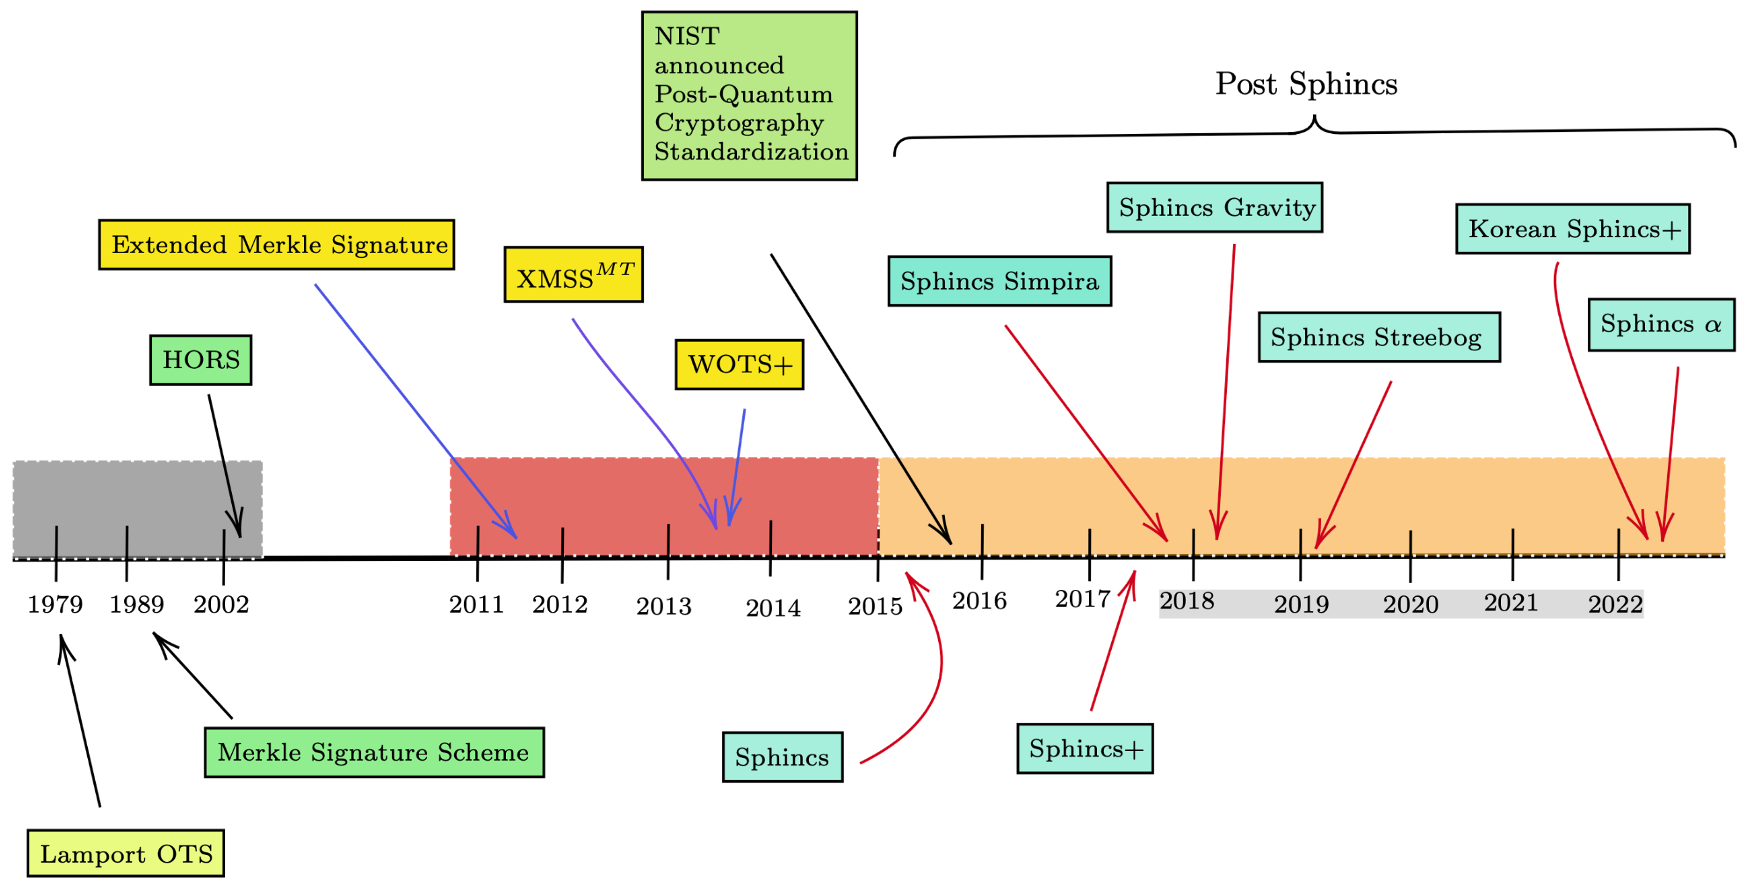

* https://www.synacktiv.com/publications/quantum-readiness-hash-based-signatures
* https://eprint.iacr.org/2023/411.pdf
* https://joostrijneveld.nl/talks/20180626_google-web-sec-summit_poster.pdf
* https://research.dorahacks.io/2022/12/16/hash-based-post-quantum-signatures-2/
* https://er4hn.info/blog/2023.12.16-sphincs_plus-step-by-step/


# Signing one bit with a Hash function

In [ ]:
#@title Depencies
import numpy as np
import hashlib
import secrets
from google.colab import files
import os
import time
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive

En este cuaderno exploraremos como podemos construir un sistema de firmas usando funciones hash.

El esquema de este tipo ya estandarizado por el NIST es el conocido como Stateless hash-based digital signature algorithm (SLH-DSA). Este esquema se compone de diferentes esquemas más simples: WOTS, XMSS, FORS y SLH-DSA Hypertree.

Por simplicidad trabajaremos con parámetros concretos. Por ejemplo, como función hash usaremos SHA3-256, que recibe una entrada de longitud variable y produce una salida de 32 bytes.

In [ ]:
#@title Base Hash function
def H(B):
  hash_obj = hashlib.sha3_256()
  hash_obj.update(B)
  hash = hash_obj.digest()
  return hash

Podemos probar a hacer el hash de un texto, previamente convertido en bytes. Observamos la salida en hexadecimal, donde cada dos letras o números representan un byte. En total obtenemos 32 bytes.

In [ ]:
print(H(b'Hola').hex())

e80b9c74112cae76f10f35ef86a6c2fbbe011d22c4d283addb4c4d3b0c513e36


Las firmas con HASH tienen más de 40 años si bien su evolución ha sido algo más lenta que los algoritmos clásicos que hemos visto hasta ahora debido a que no había una demanda por parte de la industria.
Para hacernos una idea de como funcionan estos esquemas, pensemos que Alice quiere firmar un mensaje de un solo bit, es decir, un $0$ o un $1$. La generación del par de claves sería como sigue:

1.   Alice genera dos arrays aleatorios $S_0$ y $S_1$. La tupla $(S_{0},S_{1})$ será la clave privada.
2.   Alice calcula el hash de estos dos arrays, $P_{0}=H(S_{0})$ y $P_{1}=H(S_{1})$. La tupla $(P_{0},P_{1})$ será la clave pública.

Una vez hecho el setup, pensemos que Alice quiere firmar un mensaje $b$ consistente en un solo bit para enviarselo a Bob. En este caso la firma será $S_{b}$. Si $b'$ es el mensaje que recibe Bob, asumiendo que algún atacante haya podido modificarlo por el camino, para realizar la verificación Bob comprueba si $H(S_{b})=P_{b'}$. Si coindiden, significa que $b=b'$ y el mensaje no se ha modificado. Además, se puede demostrar a un tercero que Alice ha firmado el mensaje, es decir, cualquier persona que tenga el certificado de Alice para las claves $(P_{0},P_{1})$, la firma $S_{b}$ y el mensaje $b$ puede comprobar la validez de la firma.

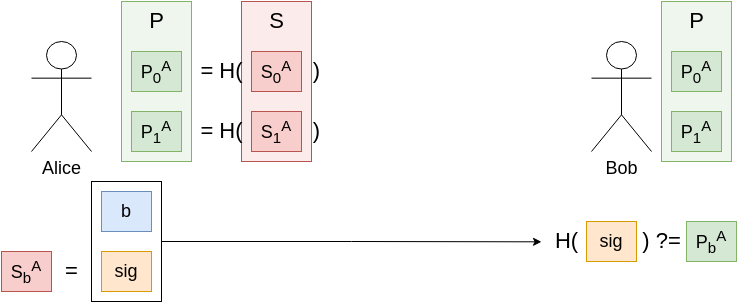

* ¿Qué longitud tienen la clave pública si asumimos un hash de $256$ bits?
* ¿Y la clave privada?
* ¿Y la firma?

Esta es la base del esquema de firma de Lamport que se definió en 1979 para mensajes de longitud arbitraria.

#Lamport Signature (1979)

En el esquema de Lamport generaliza esta idea para mensajes de $n$ bits, generando $n$ pares de clave $S_{i}$ y sus correspondientes $P_{i}=H(S_{i})$. La clave pública en este caso es la tupla formada por todas las $P_{i}$.



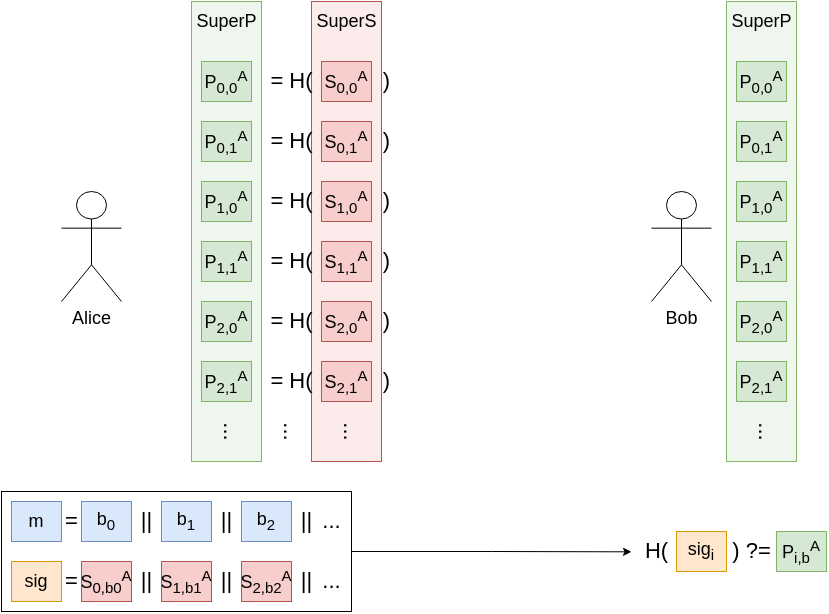

## Firma de Lamport para caracteres (8 bits)

In [ ]:
#@title 8-bit Lamport Signature

def bytes_to_bits(byte_array):
    """
    Convierte un array de bytes en una lista de bits.

    :param byte_array: Array de bytes (bytes o bytearray).
    :return: Lista de bits (0s y 1s).
    """
    bits = []
    for byte in byte_array:
        # Cada byte se convierte en 8 bits y se agregan a la lista
        bits.extend([int(bit) for bit in f"{byte:08b}"])
    return bits

def pk_to_hex(pk):
    """
    Convierte una lista de listas de byte arrays (cada uno de 256 bits / 32 bytes) a un string hexadecimal concatenado.

    :param pk: Lista de listas de byte arrays (2 elementos por sublista, cada uno de 32 bytes).
    :return: String hexadecimal concatenado.
    """
    return ''.join(byte_array.hex() for sublist in pk for byte_array in sublist)


def hex_to_pk(pk_string):
    """
    Convierte un string hexadecimal en una lista de listas de byte arrays.

    Se asume que:
    - Cada byte array tiene 256 bits (32 bytes).
    - Cada sublista tiene exactamente 2 elementos.

    :param pk_string: String hexadecimal concatenado.
    :return: Lista de listas de byte arrays.
    """
    element_size = 32 * 2  # 32 bytes = 64 caracteres hexadecimales
    row_size = 2 * element_size  # Cada sublista tiene 2 elementos = 128 caracteres hexadecimales
    num_rows = len(pk_string) // row_size  # Calcular cuántas sublistas hay

    S = []
    pos = 0
    for _ in range(num_rows):
        sublist = [
            bytes.fromhex(pk_string[pos:pos + element_size]),
            bytes.fromhex(pk_string[pos + element_size:pos + row_size])
        ]
        S.append(sublist)
        pos += row_size
    return S

def sign_to_hex(sign):
    """
    Convierte un array de byte arrays de 256 bits en un string hexadecimal concatenado.

    :param sign: Lista de byte arrays (cada uno de 32 bytes).
    :return: String hexadecimal.
    """
    # Concatena todos los byte arrays y conviértelos a hexadecimal
    hex_string = ''.join(b.hex() for b in sign)
    return hex_string

def hex_to_sign(sign_string):
    """
    Convierte un string hexadecimal en un array de byte arrays de 256 bits.

    :param sign_string: String hexadecimal concatenado.
    :return: Lista de byte arrays (cada uno de 32 bytes).
    """
    # Cada byte array es de 256 bits (32 bytes = 64 caracteres hexadecimales)
    byte_array_list = [
        bytes.fromhex(sign_string[i:i+64]) for i in range(0, len(sign_string), 64)
    ]
    return byte_array_list

def gen_key_pair():
  """
    Genera un par de claves para el esquema de Lamport para 8-bits.

    :return: Devuelve la clave privada S y la pública P como arrays de byte_arrays de 256 bits
  """
  S=[] # Creates an empty dinamic array for the private key
  P=[] # Creates an empty dinamic array for the public key
  for i in range(8):
    A0 = secrets.randbits(256).to_bytes(32, 'big') # Generate a random byte array of 32 bytes.
    A1 = secrets.randbits(256).to_bytes(32, 'big') # Generate a random byte array of 32 bytes.
    S.append((A0,A1))
    P.append((H(A0),H(A1)))
  return S,P

def sign_lamport(m,S):
  m_bits = bytes_to_bits(m)
  sign=[]
  for i in range(8):
    sign.append(S[i][m_bits[i]])
  return sign

def verify_lamport(m,P,sign):
  m_bits = bytes_to_bits(m)
  mask=[]
  print([str(bit) for bit in m_bits])
  print
  verify=True
  for i in range(8):
    if P[i][m_bits[i]]==H(sign[i]):
      mask.append("✓")
    else:
      mask.append("x")
    verify=verify and (P[i][m_bits[i]]==H(sign[i]))
  print(mask)
  return verify

In [ ]:
#@title Key generation
S,P = gen_key_pair()
print("Public Key: ")
print(pk_to_hex(P))
print(len(pk_to_hex(P))//2," bytes")

Public Key: 
cf65147577aa6931feb54067e295e6021c4583b7f3645e5e7aaeec5ac88fe30b529f06c1f738d6e80925d0bad28a997219f683b76bbe18fcc93be1096dcd50a136ceb60bb2f8dfb5f0d5e12d7ab6c6d889d032ebb307bacd13b3fa289ba49023233047533359f702c19f072b3ce7dc544b9c136515ac4f0ce942f354784636acf0721531a2c7d352822a2812359da2456800963dc895369fbf6f0f760b17f84f25bc440c9bce63e3a700fc5e1d6db4d43a277efcec494b8f18ac3ebcb5dffd7dfa0371cd80fa421cdcc47c142aa865a3d3e6260667916533109ea2397595397758d3de685255161166002c2bd11b5db66f80ac1ba3cd9458db3627023d6a620b0c04f7e31f2771208f87cf3499e7a694c3de26d192677c0af870edc887e70717fa87330365ddc21bbb77c8b5a752f61d139a889bff4ba3d2d5baa50b86ebd0272b67a8a5158183f4a1dd0ee0cef7f36cdb913d17b7ba5df0954e98d843130d231ec474885748db86c07f04da200062dcbe4a7e8e7d61fb28ff90d693c40a4b43e921f896dc73038b0933e4e36308337dd65296528929dd89022dab8ba9b3816ffdddedd834f29e799d22106a2f34163e037efe05002fbfb403ece786111135ddef6af95cb2227c821de906cd8abefc7f2b923331ba1d3031d86d97e4c1d95c3b1ee9996e4c73cc96c0158903e2c

In [ ]:
#@title Signature of a char (8 bits)
random_number = secrets.randbits(8)
m = random_number.to_bytes(1,'big')
m = input("Enter the message (a single character): ")[0].encode('utf-8')
print("Message: ",m)
sign = sign_lamport(m,S)
print("Signature: ", sign_to_hex(sign))
print(len(sign_to_hex(sign))//2," bytes")

Enter the message (a single character): g
Message:  b'g'
Signature:  2d9d2d04f29594de77d061520ef2d3145b47297566f1ad38bd7111dfe9dc803beff2d7493304b2080142a4ae38649087719398910149b1501d048fbdda9e49c8755dbf6a796c00db14441e4677cf2ef336d8ba60b1e80309048f8f7623c5b05e48e02dc00165ad95dd2107ed8f586ecd69a00428f86062463ffe555f9465fbe4f6de0763bccc0e8cde6d53091502219e829ca9889da7394e3105382bc74d7a615990554f8411ae8858d144797c37156202342653f2dd8d49ff535504e30ac5f96b11fb2156be772c7802f6e01acb0cc7c190f2cbbc968401d3cf967afc4b5396496a0d054346578884f291c53ac9896e55054c7e704afb4fa8539226abd0457f
256  bytes


In [ ]:
#@title Verificaton of signature
P = hex_to_pk(input("Enter public key: "))
m = input("Enter the message (a single character): ")[0].encode('utf-8')
sign = hex_to_sign(input("Enter signature: "))
ok = verify_lamport(m,P,sign)
print(ok)

Enter public key: 43970c264c8ccfe52d7d26bc19bfd4ea662aa037cc3774a26a4a1462c45c4aace8ed6f78121f6dabe9cacbec7f20a8246ac9fa48e7953a28f58efaf9d27859e4cc130a1e16db29c19365228288959f73be9eeb99b6006f50bc95d293d136f24a12e294a59404e53f15a7bb1561ad3e9507f4cb2dbfc38079815e8727f611865176f0aa627191f5a3b3964c7e078c7f575ae73bc8d71e189bd24e21cf9d0efcc52c5eaa3bd334b209e8be8ed8f34450abc714a02a3f86011e9e0cfa037900691d9ce86df0448c00c83ce4d50ef45f121fd91bafd04460323dd786a905192ebe086e4484c876db0bef3c2c0ec38d6bc1986b33db4c040c6ffcb20fba6f5b2e4a965cb6ac9acedf5d91d5a7c4c6d4916a63d0828704d4eb1b626ba496901d1310f39d88f16bcdde891a3ceef1e46ff55e605677f4eb5f890a22f1d3c83f6240f1e4ce25ef7d11462a846a31b3dfd42407ba34b4116448293f353050844e09a2afe49f1b0d2e9984c60182769363ec9ca7ccf8e4f055f0347a9c10fd2d82ef5b0d2ee3258107e9b42c904a768b20c59015c6a4f54b5b37702cf65d44b1839480be8f85eb609b472d19a1ad96b706db454ab4a6e2aabc8f8d2cc68d5311b3ea8cafe77dfaa007c949bc49c336e93002fd0e17527fbb4e9a2c9cc61e64229a1ba7418af3bd7c44b57262dd9c15f3

## Firma de Lamport para 256 bits

Generaliza el código anterior para firmar 32 caracteres, es decir, 256 bits.

* ¿Que longitud tiene la clave pública?
* ¿Que longitud tiene la clave privada?
* ¿Que longitud tiene la clave firma?

¿Como podría usar esta este esquema generalizado de 32 bytes para firmar archivos de cualquier longitud?

#Winternitz One-Time Signature (WOTS)

El esquema de Lamport tiene claves y firmas muy grandes, el esquema de Winternitz intenta solucionar este problema con una aproximación muy ingeniosa. Se puede autenticar un mensaje de $n$ bits de la siguiente manera. La clave privada es un array aleatorio $S$ y la clave pública es $P=H^{2^k-1}(S)$. Para firmar un mensaje, lo pasamos a decimal y nos quedará un número $m < 2^{k}$. La firma es $sign=H^{m}(S)$. A la hora de verificar, se calcula la diferencia $v=2^{k}-1-m$ y se comprueba si $H^{v}(sign)==P$

En general, la clave privada ahora es un array de $n/k$ byte arrays de $32$ bytes, donde $k$ es el factor de reducción o de compromiso. Para conseguir esa reducción en espacio, el esquema require una mayor carga de computación. Como hemos visto antes en el ejemplo, el objetivo es que cada array de la firma autentique en lugar de un solo bit, $k$ bits. Ese factor de reducción se consigue haciendo que la clave pública sea una lista de hashes de este tipo $H^{2^k-1}(S[i])$. Cuando mayor sea $k$ mas computación será necesaria para la firma y verificación, pero menor espacio ocupará la firma al haber menos elementos.

Pensemos en un setup para mensajes de 10 bits, donde queremos que la firma solo tenga 5 elementos. Tendremos por tando un factor de compromiso de 2. La clave privada es
$$[S_{0},S_{1},S_{2},S_{3},S_{4}]$$
y la clave pública es
$$[H^{4}(S_{0}),H^{4}(S_{1}),H^{4}(S_{2}),H^{4}(S_{3}),H^{4}(S_{4})]$$

En la siguiente imágen vemos la firma de un mensaje de 10 bits, separado en 5 bloques de 2 bits: 10 00 11 01 00. Si pasamos cada bloque a decimal nos queda 2 0 3 1 0. La firma sería [$H^{2}(S_{0}),S_{1},H^{3}(S_{2}),H(S_{3}),S_{4}$]

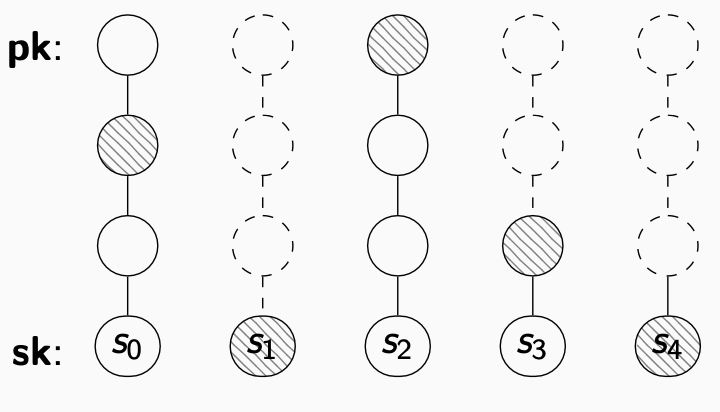

Esto tiene un problema y es que a partir de una firma dada, salvo que el mensaje a firmar fuera justamente 11 11 11 11 11, un atacante podría aprovechar los valores de la firma de poder firmar calquier mensaje donde todos los bloques en decimal fueran mayores o iguales que los bloques originales. Por ejemplo, podría firmar el mensaje 11 01 11 01 00 (3 1 3 1 0)

## WOTS simple (First approach)

Vamos a implementar un esquema donde el factor de compromiso sea $4$ y por tanto tengamos que hacer el hash $2^{4}-1=15$ veces para calcular la clave pública.
Hemos optimizado el almacenamiento de la clave privada generando los valores $S_{i}$ en base a una semilla $sk$ de 256 bits y a un contador i, de la siguiente manera $S_{i}=H(sk||i)$. Con esto reducimos el tamaño de la clave privada.

In [ ]:
#@title WOTS simple key generation
def wots_gen():
  sk = secrets.randbits(256).to_bytes(32, 'big') # Generate a random byte array of 32 bytes.
  P = []
  for i in range(64):
    #print((sk+i.to_bytes(2,'big')).hex())
    A = H(sk+i.to_bytes(2,'big'))
    for j in range(15):
      A = H(A)
    P.append(A)
  return sk,P

# Concatenate and print P in hexadecimal
def wots_pk_to_hex(P):
  return "".join([element.hex() for element in P])

* ¿Que longitud tiene la clave pública?
* ¿Que longitud tiene la clave privada?

In [ ]:
sk,P = wots_gen()

print(sk.hex())
print(len(sk))




print(wots_pk_to_hex(P))
print(len(wots_pk_to_hex(P))//2)


6572d6f9a35af559a13126e89b295cd879f488c856d3b6245161d00790e30c17
32
53d4842430770af4f4787e85b4da375fd42958001c0816f4e0d0298f758abfc3057dac1721b69b8c9b9bccb9f346f2f0900e76d9b5aaffc56d6bb6a83f05fc8fa779d78ecd834ae1209f7c8b12be2ad8227c0a62e201849589050bf621937d8d159b96afb39f0cafcd3f723d6994f90c102d819b819dcb6bd48a39011eabad4ba0cde9b537579cc2cf97119794722128eebeca4f12c942ed1b4cbd57101e1cd2cfc0f44a968a2d39f3227f076e759efb1c38fa62aaa3c122e5933d9ca3f8a1a3aa1b0250a579f75b70e7b5da05ad68ca283f3da614152fe513a03f8f3cf3c8a108a20292a94de0868e5b7ac40c8817dc8fb6616cdb36b14a36d0a1f9520c85f33bff3e514b04c3c326037e308d2babcdb63a4c2c30fb4e19ecf098d9f785302fa8b8ae66d2b6ee0b345c8852481576a4662d7e094f08cff41ab2350acd22950153b081a3d6612848d0fc0a76d420691740251fe9a868868c21020001ae2d424130d3ae7df5ae2f880f7f7d2a84c8acc30e2f3eba76a8bba741ae702795e0d3a51391429278ecdae8be946bd6847e970b71256490e833c382fd98fe81fd2b98beddf221eb81a8d851771ece68d7eb97936625502bdb009cd02e48aa83eb8059a8d13028235344728d701f72e52c669e11856e

Una vez hemos generado los pares de claves S y P, realizar una firma es muy simple. Solo tenemos que recorrer el mensaje en bloques de 4 bits y aplicar el hash al elemento $S_i$ tantas veces como indique el valor del bloque en decimal. De esta forma convertimos el array $S$ en la firma del mensaje.

In [ ]:
#@title WOTS simple signature

def wots_sign(m,sk):

  #Pasamos el mensaje m a hexadecimal para que cada caracter coincida con un bloque de 4 bits del mensaje original. Tendremos un total de 64 bloques para un mensaje de 256 bits
  msg = m.hex()
  S=[]
  #La firma la almacenaremos en S de forma temporal
  for i in range(64):
    A = H(sk+i.to_bytes(2,'big'))
    S.append(A)
    for j in range(int(msg[i],16)):
      S[i] = H(S[i])
  return S

Ahora tenemos que implementar la verficación. En este caso tenemos que volver a recorrer el mensaje bloque a bloque y aplicar a cada elemento de la firma la función hash $2^{k}-1-m$ veces, donde $m$ es el valor decimal de cada bloque de 4 bits.

In [ ]:
#@title WOTS simple verification

def wots_verify(m,sign,P):
  #Pasamos el mensaje m a hexadecimal para que cada caracter coincida con un bloque de 4 bits del mensaje original. Tendremos un total de 64 bloques para un mensaje de 256 bits
  msg = m.hex()
  #La avanzamo los hash de la firma según lo que indique cada bloque.
  for i in range(64):
    for j in range(15-int(msg[i],16)):
      sign[i] = H(sign[i])
  ok= True
  for i in range(64):
    ok = ok and (P[i]==sign[i])
  return ok

Vamos a probar que todo funciona correctamente


In [ ]:

sk,P = wots_gen()
print(sk.hex())
pk_hex = wots_pk_to_hex(P)
print(pk_hex)

m = secrets.randbits(256).to_bytes(32, 'big')

sign= wots_sign(m,sk)
sign_hex = wots_pk_to_hex(sign)
print(sign_hex)

verify = wots_verify(m,sign,P)

print(verify)

6255495ea145ef65c072c77d7b6793a5dc016b36d42b5c3a689b7555274971bc
5daa9d1f68783ddd9dc932746daaa5010ab21c8b4a51c19cf5aa64492c2d2f3fe3ea7983d9634168f246509109aad44452f2f7b9b2175818fb9b7a7e41ab194b95e896cf863ba7e531d411df37306a6994e669ce5abcd38774b2b8c25a194f2b382a211167cbe3f83f516bfba127ed5925c1d8c5eaf4e160434362056559a09b03496e853cbb6d3b2f0f82e3deb34d3fd371898eeefdeb86acce9e21d9e6be7169af91ded39dfda014c6e2eeea0554447223f2d5e541f838ac891ffdb97c279bbd52d767d54dc3132f99c58b1055e5f5b550cfe04144b5f79b1ce85ff83a5f8954ab4957187aeab423218b371dab8941f2e74e48853a76c140d829c6f0c5282224d4e50b8c7a5e520abaa0a6c389eb59f85bfb554c505eb09c313bd2af2602eb1bba52cd59170a9df68f7190eb35d6fe27b798f14bce27969b71054c5e36bc841223127140f54f6ea3b292aa73b736ccc70178b5f37efd346e956c42e46909dfb1892d9ef404c8bf4c4e8931c4e90cd23d61065a2f99aeefe1d66bd30d8a4ad30277485e33075148842f7ce5416d34cada1b09ab97f5f604e078390971116a423eabfb3b171c3168c99661cbee1c03b3af487f98c84cb7a4325da077c357afd6ba64892f27c92b596272b50410b1e08f8350723

1. A partir de una firma dada, crea una firma para otro mensaje diferente usando la idea que comentamos anteriormente
2. Una forma fácil de evitar que se puedan falsificar firmas avanzando los hash de una firma dada es firmar tanto el mensaje $m$ como su complementario. De esta forma si alguien quisiera firmar un nuevo mensaje $m'$ avanzando el hash de la firma, se encontraría con el problema que en el complemtario tendría que ir hacia atrás. En base al código proporcionado implementa un esquema de firma para mensajes de 128 bits que sea resistente a falsificaciones de firmas y compruebalo.
3. Si en lugar de publicar todos los hashes de la clave pública, hacemos público el hash de todos ellos, el sistema sigue funcionando y siendo seguro. La diferencia es que en la verificación hay que concatenar todos los arrays obtenidos, hacerles el hash y luego compararlos con la clave pública. De esta forma, el clave pública se reduce a un valor de 256 bits solamente!




In [ ]:
def wots_gen_compacto(sk):
  P = bytes()
  for i in range(64):
    #print((sk+i.to_bytes(2,'big')).hex())
    A = H(sk+i.to_bytes(2,'big'))
    for j in range(15):
      A = H(A)
    P+=A
  pk = H(P)
  return sk,pk

def wots_gen_compacto_2(sk):
  h= hashlib.sha3_256()
  for i in range(64):
    #print((sk+i.to_bytes(2,'big')).hex())
    A = H(sk+i.to_bytes(2,'big'))
    for j in range(15):
      A = H(A)
    h.update(A)
  pk = h.digest()
  return sk,pk

def wots_pk_candidate_compacto_2(m,sign):
  h= hashlib.sha3_256()
  #Pasamos el mensaje m a hexadecimal para que cada caracter coincida con un bloque de 4 bits del mensaje original. Tendremos un total de 64 bloques para un mensaje de 256 bits
  msg = m.hex()
  #La avanzamo los hash de la firma según lo que indique cada bloque.
  for i in range(64):
    for j in range(15-int(msg[i],16)):
      sign[i] = H(sign[i])
    h.update(sign[i])
  pk_candidate = h.digest()
  return pk_candidate

def wots_verify_compacto_2(m,sign,pk):
  pk_candidate = wots_pk_candidate_compacto_2(m,sign)
  return (pk == pk_candidate)

In [ ]:
sk = os.urandom(32)
print("Clave privada: "+sk.hex())

m = secrets.randbits(256).to_bytes(32, 'big')
print("Mensaje: "+sk.hex())



Clave privada: 46813e0831bc4b4f3edba29b3abf4940a68a00eb26534a508b5abd5d45437e9a
Mensaje: 46813e0831bc4b4f3edba29b3abf4940a68a00eb26534a508b5abd5d45437e9a


In [ ]:
sk,pk = wots_gen_compacto(sk)
print(pk.hex())
sk,pk = wots_gen_compacto_2(sk)
print(pk.hex())

print("Vamos a firmar algo:\n")
sign= wots_sign(m,sk)
sign_hex = wots_pk_to_hex(sign)
print(sign_hex)

print(wots_verify_compacto_2(m,sign,pk))

4b61569ce797d1b473411c41300e45bfc9347f1cfb9f6d11400cf0884e4aab03
4b61569ce797d1b473411c41300e45bfc9347f1cfb9f6d11400cf0884e4aab03
Vamos a firmar algo:

b91fbaea448ca67669a6eae0d696da2cf679332a3ddf724ad30179dc193f79b1d2ba347a4967094bd7ca1d496aba34aa2e558605502b31f7882a751bfa9e11c42734b60708c207ceccf141da3a759b7259e07367d8833ce26141949bf939be2893a043b0a58cf42312ab628eeddd920dd3b997112e2e847e75339afc8e1d7246e2d48b7811a82f49f4941e140c5310d643445771e2aa2aa13f0baacc2cfa1345bcac52aee2ef2c73dd70e9e0a9c47b4af9a74f3fdcde41eea85f5cb31d1c31150f1b1dcfb09a3d75d948bd5223f8e6c73ba600534582c6536432fad544bcd53fb0a4807080d43f0ca87f4229989d48c6ac6073b34c06757d20bf5b22f967eab3258804680e7a04c3058c3fe55023053856ab2af5638c2205bba5662eff2451ba4661af74b55dc969a5a214a0e8148c87107b57ce5c7082dcce63bb3be0ebcb824d9d573f244c668edefcfef1b24d46e28be10c353ca2f5522f631a81bbeb9f82d6bc917b193e3c40b2eb236ae4133bef117f1674c1ad418545253b1e59bc37d8dc78bb0afa860d88cdbd682c97cc5af2fa4d3ebbc394f146a7bf49e155dc1f3b44f3ff0d30fec2da

## WOTS

En el esquema WOTS  que se utiliza hoy en dia en otros estandares como XMSS se usa un checksum de 12 bits que es sufciente para evitar los ataques de falsificación. Esto hace que tengamos 3 bloques de 4 bits adicionales en cada firma y también en las claves. Por tanto, en nuestra versión de WOTS, la clave secreta consistirá de 67 cadenas cada una de 32 bytes. En vez de guardar 67*32 bytes, guardaremos una semilla de 32 bytes generada aleatoriamente usando la optimización que vimos en el apartado anterior. A partir de esta semilla y la función hash H, obtendremos los 67 valores secretos. Para ello, concatenaremos la semilla al índice de la cadena (un byte que represente un valor entre 0 (0x00) y 66 (0x42)), tras lo cual aplicaremos H. Las propiedades de las funciones hash nos garantizan que obtendremos cadenas completamente diferentes (modificar, añadir o eliminar un solo byte modifica completamente el hash).
La clave pública consistirá en aplicar la función hash H 15 veces a cada una de estas 67 cadenas. Obtendremos por tanto 67 nuevas cadenas de 32 bytes. Para ahorrar espacio, las concatenaremos y su hash será la clave pública (32 bytes).

El siguiente algoritmo se encarga de producir un par de claves WOTS.

In [ ]:
def wots_gen():
  sk = secrets.randbits(256).to_bytes(32, 'big') # Generate a random byte array of 32 bytes.
  pk = bytes()

  for i in range(67):
    A = H(sk + i.to_bytes(length=1,byteorder='big'))
    for j in range(15):
      A = H(A)
    pk += A
  print(pk.hex())
  pk = H(pk)
  return pk,sk

Más adelante usaremos WOTS como subalgoritmo, y nos interasará usar como sk una clave concreta. En ese caso, usamos la siguiente variante del algoritmo anterior en la que especificamos la semilla sk, y obtenemos la clave pública pk asociada.

In [ ]:
def wots_pk_from_sk(sk):
  pk = bytes()

  for i in range(67):
    A = H(sk + i.to_bytes(length=1,byteorder='big'))
    for j in range(15):
      A = H(A)
    pk += A

  pk = H(pk)
  return pk

Probemos a generar un par de claves:

In [ ]:
pk,sk = wots_gen()
print("pk=",pk.hex())
print("sk=",sk.hex())

fd962f9b7f13b018a4040368b7fbad68c596ec70788d8462f81463924c716c928be1cc6939ac4e10bd6a64349b4a97f932ea770f6aa2a19e21bc68b6da127f55b1a194c99b93079685f3105d29fcacfc9f5ff7790c5b09f0fe29d563e299fadd1731499ff107d9d5bf169b733d5bdce1785bf146ff4343a8df566ea5792736d3859433ace2a8df3654d65de0cd3b0154326c21339277a520dac688fa38d8cf35c4a9f8d873af2cb1d1c82584098d8343e9d3ecbe4a161a7a03b363a6996cba6793a5b7578e20ddfbdb62b423ff6305bbe189525f59242733816e58b5fc9f5e8c2032cfd2540a9ea5f43a50849d89ca65ccff73ca33355b82e3adc8c130d581d4c588376665de2ab1c22922483d1763d7355f6a99739b0d297d47f3a65a336d88c774365b5c1ed4579566cf032c612e6ba3406a6f844552ac19a8d3f7a064cdb13c667bac468a92e1edfed5ca6a4ac7cf8886a8580ba219320a6a7ca5cd151921122e82db10448e4dc69c3f1fad26252432bc91f9da53bc9264917f6a0ac5a14fb7ffc10b2963023827e46e586804e8f774abd39b3a0a51c3732241be5c45dacbad6dfc1d03ef3982bac7cc43f41381fc7668126422fea046811bd460f398a725c048e9dceb8c8e1d39494ada44b92725771cc177cf466d9264d56e0091fdf4c5cc8189b3551e91adfa9e2d8295b0094c02fd0aed

En este algoritmo, la firma consiste en publicar las cadenas secretas tras aplicarles la función hash H un número concreto de veces a cada una. Por ejemplo, una firma puede consistir en publicar la primera cadena secreta tras aplicarle H 7 veces, la segunda cadena tras aplicarle H 15 veces, la tercera cadena tras aplicarle H 0 veces (es decir, la propia cadena), etc...

Las veces que tenemos que aplicar H a cada cadena vienen determinadas a partir del mensaje que queremos firmar (realmente a partir del hash de dicho mensaje), y siempre son números menores que 16.

Para firmar un mensaje, primero obtendremos su hash de 32 bytes, o lo que es lo mismo 256 bits. Dividiremos los 256 bits en 64 grupos de 4 bits, y cada grupo de 4 bits representará un número entre 0 y 15. Estos números nos indicarán cuantas veces aplicar H a las primeras 64 cadenas secretas.

¿Y las 3 últimas cadenas?
Lo que haremos será sumar 15 menos cada uno de los 64 números entre 0 y 15 obtenidos anteriormente, y representaremos la suma obtenida mediante 12 bits. Estos 12 bits se dividirán en 3 grupos de 4, los cuáles nos indicarán los 3 números restantes.

La firma tendrá una longitud de 32*67=2144 bytes.

El siguiente algoritmo implementa el proceso de firma descrito anteriormente. Los parámetros serán la clave secreta y el mensaje a firmar.

In [ ]:
#@title WOTS Signature

def wots_sign(M,sk):
  #M: mensaje, para firmarlo tendremos que convertirlo primero a bytes mediante H.
  if isinstance(M, bytes): #En algunos algoritmos que usan wots_sign puede que M ya venga dado en bytes, por lo que distinguimos ambos casos
    msg = M.hex()
  else:
    msg = H(M.encode("utf-8")).hex() #firmamos el hash del mensaje
  signature = bytes()
  checksum_int = 0

  for i in range(64):
    sign_element = H(sk + i.to_bytes(length=1,byteorder='big'))
    checksum_int += 15 - int(msg[i],16)
    for j in range(int(msg[i],16)):
      sign_element = H(sign_element)
    signature += sign_element

  #salen 2 bytes, 4 caracters hexadecimales, pero solo necesitamos los 3 menos significativos
  checksum = checksum_int.to_bytes(length=2,byteorder='big').hex()[1:]

  for i in range(3):
    sign_element = H(sk + (i+64).to_bytes(length=1,byteorder='big'))
    for j in range(int(checksum[i],16)):
      sign_element = H(sign_element)
    signature += sign_element

  return signature


Podemos ver el parecido con el algoritmo real usado por el NIST:

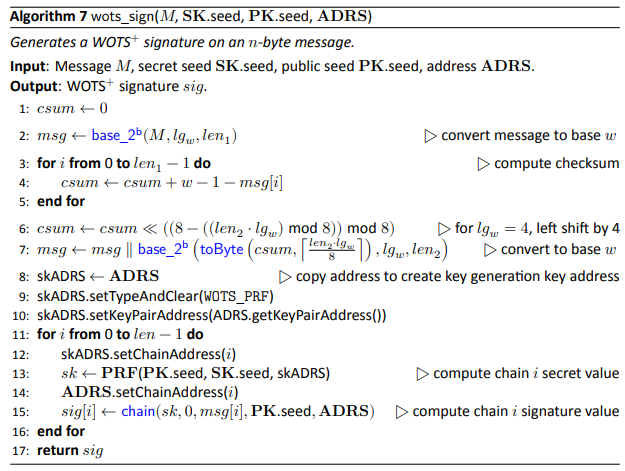

En la imagen anterior, w=16, y chain es la función utilizada para aplicar la función hash sucesivas veces.

Veamos cómo se ve la firma de un mensaje:

In [ ]:
M = input("Enter the message: ")
signature = wots_sign(M,sk)
print("Firma: ",signature.hex())
print("Longitud de la firma:",len(signature),"bytes")

Enter the message: hola
Firma:  98ca7738eaca3baa1480cbb0db81955d846122f79554d126d95f5e4e3d915a1fd4c0c4dcf25ecddb1c1e0c23ff877158638adffa0354387bc4bde6f9d43e9e75b1a194c99b93079685f3105d29fcacfc9f5ff7790c5b09f0fe29d563e299faddbcba9f2bc133f43e66e9d3c8c0e602b653e869c71a5d8d293b853f7a1545840138866842f4a0106d552e2e1b3a3f7a7fe1e87c21b52f1bb0a7e916ca3a243de273fc5be023e24c720ec998337ae49993ff92cb94198b88250ef75fba58b8702b2f7c69dbeba37368116d0900e3b3b2146e73d509ebfb7e38592f47310e758e26172cfaf9ce4c6343c14b423e83cd7bd1270db560dfe679bf350ff31b381cc0e7262155e527f0a46a61d700dfd457260ff419f4dad7b7ccbe34077024f686e6b0cde02271caf14086d3062b4dfcfcabf21ff12e496d4b22514dc2384f9a23239babc5032793384164d931afd6e9f4e79ecb898f69d732b96841665a835ad173a608548660761596ab6b6b1965ccc16ff0e45817dd61094bc4806efa0f96f4cfd74c435cf77c3b119938bcf4b77872c45f1befbc6a38764fb71cdb379c0574e6f2fa5e7e794cabde055176a8e6a32a0f9fdddc8412126d9fc1c22bd413cf847cc61af28fcdfd4610364874b0460ea716b17d32a8b3b16bf08c01da63d4dfd7a7bad074dce6

Para verificar si la firma de un mensaje es correcta, primero usaremos el mensaje para calcular los 67 números que se deben de haber usado para decidir cuántas veces aplicar la función H a cada valor secreto.

En base a lo anterior, aplicaremos la función H a cada una de las 67 cadenas de 32 bytes que componen la firma las veces necesarias para que el resultado sean las cadenas secretas tras aplicar H 15 veces. Por ejemplo, si la primera cadena de la firma tiene que ser la primera cadena secreta tras aplicar H 7 veces, lo que haremos será aplicar H otras 8 veces a dicha cadena, pues 7+8=15.

Finalmente, concatenaremos todas las cadenas obtenidas y aplicaremos el hash. Si la firma es correcta, la cadena de 32 bytes obtenida debe coincidir con la clave pública.

El siguiente algoritmo implementa el proceso de verificación, dados el mensaje, la firma y la clave pública:

Cuando usemos WOTS como subalgoritmo, sólo nos interesará quién es pk_candidate dados M y signature, con lo que primero implementaremos un algoritmo que nos genere la clave pública candidata en base a la firma y al mensaje y luego lo usamos para definir otra función que nos diga que la firma es correcta o no.

In [ ]:
def wots_pk_from_signature(M,signature):
  if isinstance(M, bytes):
    msg = M.hex()
  else:
    msg = H(M.encode("utf-8")).hex()
  pk_candidate = bytes()
  checksum_int = 0

  # Split the signature into 67 parts: 64(payload) + 3(checksym)
  payload_sign_list = [signature[j*32:(j+1)*32] for j in range(64)]
  checksum_sign_list = [signature[j*32:(j+1)*32] for j in range(64,67)]

  for i in range(64):
    A = payload_sign_list[i]
    checksum_int += 15 - int(msg[i],16)
    for j in range(15-int(msg[i],16)):
      A = H(A)
    pk_candidate += A

  #salen 2 bytes, 4 caracters hexadecimales, pero solo necesitamos los 3 menos significativos
  checksum = checksum_int.to_bytes(length=2,byteorder='big').hex()[1:]

  for i in range(3):
    A = checksum_sign_list[i]
    for j in range(15-int(checksum[i],16)):
      A = H(A)
    pk_candidate += A
  pk_candidate = H(pk_candidate)
  return pk_candidate

In [ ]:
#@title WOTS Verification

def wots_verify(M,signature,pk):

  pk_candidate = wots_pk_from_signature(M,signature)

  return pk_candidate==pk

Podemos ver el parecido con el algoritmo del NIST:

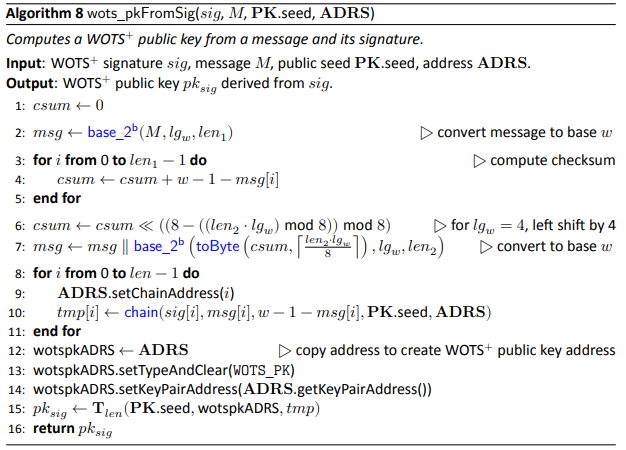

Veamos un ejemplo de firma de un mensaje y de una verificación correcta y otra errónea.

In [ ]:
pk = bytes.fromhex("8c945cefcd00dc86efd35961c690861e24a38714f794dc74f8bf66b32da79ce6")
M = "hola"
signature = bytes.fromhex("98ca7738eaca3baa1480cbb0db81955d846122f79554d126d95f5e4e3d915a1fd4c0c4dcf25ecddb1c1e0c23ff877158638adffa0354387bc4bde6f9d43e9e75b1a194c99b93079685f3105d29fcacfc9f5ff7790c5b09f0fe29d563e299faddbcba9f2bc133f43e66e9d3c8c0e602b653e869c71a5d8d293b853f7a1545840138866842f4a0106d552e2e1b3a3f7a7fe1e87c21b52f1bb0a7e916ca3a243de273fc5be023e24c720ec998337ae49993ff92cb94198b88250ef75fba58b8702b2f7c69dbeba37368116d0900e3b3b2146e73d509ebfb7e38592f47310e758e26172cfaf9ce4c6343c14b423e83cd7bd1270db560dfe679bf350ff31b381cc0e7262155e527f0a46a61d700dfd457260ff419f4dad7b7ccbe34077024f686e6b0cde02271caf14086d3062b4dfcfcabf21ff12e496d4b22514dc2384f9a23239babc5032793384164d931afd6e9f4e79ecb898f69d732b96841665a835ad173a608548660761596ab6b6b1965ccc16ff0e45817dd61094bc4806efa0f96f4cfd74c435cf77c3b119938bcf4b77872c45f1befbc6a38764fb71cdb379c0574e6f2fa5e7e794cabde055176a8e6a32a0f9fdddc8412126d9fc1c22bd413cf847cc61af28fcdfd4610364874b0460ea716b17d32a8b3b16bf08c01da63d4dfd7a7bad074dce62d662e5deb0d9327f20b5672a065475367ea197e3847e19bd70bbb383398493b1666bd02ead8493bcffa080d7990729e1793f0879918eaa2616ab37348acf7f73c31b043c27df38dbd837da932e175b033e923384882c6700571861b3a77d6187c59572b8def6da09282dd40cf9ee6bd1f88613220c0d07ce59a642c77cd103e6a3ac6c40b32199616daa9a75b4fc6555047f8c4c7deadbc183e2c6c070c7c1c3a646ed189223b8eea6d46f34a657a1e3b21125dba66fe84b2254393c96b43ae6cd5f95ba0f51b1083184a06887533c85921d8ff1c71024cb7640171cbded1926bcd8fdf0b042692a5361fc5340d557c8a8802b577669f7ab8bdc0c8cbe419228dede499239d0ccd6f90ce07396ebf430da5f7940044697d51b83ccbfa92927271732db7f46ac28dde6900ab338abc46cf43babb014bb2b1798a6dd59d99ceb815021aeebfdf22f03a074bf10dfc31ae6ecaa97f1932686f7789c1b14de1a519aeec2b436f16acee5266a1c9a5f05bd24a2dfe603ce054c5e34fd26e08705eb9659e33f33e53617aaee148d90cc3400edb0cbc4060b5119c292931523a043bada0bdb54f856b78867ef1200af9dd13e5578938ae6c70dc355eb0b96731bfebb8553ce29cb6bbf4f797dc7e851c254815367ce980a16f360ee85a9b796247c9cf8e21fc9ad27776efe5ad0f83752e7c6bd71da630c0f892fe87bacf5148c91d1bb47a7e120b7b1d7227f617d8ccfaac685320d2819d21672f5976ee7a022b1969eb8cad52b0a8e59c32e838555fa8963e8895f5975d40fa75f905f0a4ba6c297cec20c62df65f276b82cca80694435242955809db7cd925db6eb689eef3f017142ac84765f9af6a5e7a6c3bab6837eb4c7f45ee9991a55ddaf87000968a0b19b387f43fe487adb6797fcb5f6ff98cf6eea6464cb504a47c090c23d0d253b51d6cc773f47474a45c5f72a0ed480c30a1fcc0ab55dc197bec6141ad55a7b3378cba369a30d9e17ac2a626ae9bd5bf9245d687079ad8c2aea64343a9099a1e2ea7031826f58dd133ef14e690bd443f3f5e8451b2cdfde94d66d4547e496c95a07d59f7882aa445753854d4b7f8e8dc3925ca790f5f57d18471d919d7da545439b94d50e5e9209fba852c9437231d63697a16e1c09d343ca0b7703aa1a6a402b1481db118d5ab42cab82aa20ee09f18bf695c166006b0d4ad955aa7ff2f2f5716c1b5c48a518f0f8220e10b956afa19509801336f2329ccce28bbd6ceb10dc4158a7f4f4227f803330db30596efbdb453b0a9fbec145434fef92a07f21a32d88f46d6fb3d7c9f91f333a8ade17a584e7caaccf44eadffd2ea9a2e0442ab8fc1b8f9fe0ae49fda50621a81bbe3160ea314ceed375ec47a4bf5004a04c28bb634deda617f580c9b19b3b97fd89aa22c4af3e59de3d48263aa47c8524024f495f4eed60cbeefb69baae22fd806a813f9cd1c001ce0437df3cddee91ca52f05792376670c1175e1e7c0d4178be91598ed86b11744f915f9e60c275a652e5dabc40f82a5789d4655d97f9eca3fa7f1035aeefc3e6ae517b501b59e3c0524a1802846acc74a024670ee83a923f7659eb4f7e62497ba43a461c0506bf9ef8cd08e7bcc83bab0bcc71a2bd94b40df0be943c2c90ac387f014fe3203455970178ddc5e3bd03fa7cb5ef507e2500133220d2fd435a46993e5de7c6e35f8778c5fca796a1e8787f896b57b5129913354aa7c70e59f92381c6ac052c91c8e98dd4ba0960c25208c3e1b60fd54c329c1e7f1b85aadeeb444383b74b55bc0b5984ff02704a565aa69359c47d5751f4624650f76a57d8ed1ea29779cab8f8858de402ec0e246b8bd21b0ac5986f00054b09c17c44ac0c15e483bdf160a5d5d8d720b21fecfbcae2b16e9aa8b251396d779aa789cec100ea2655bd1f2cd7cb202a3bf88ce8ad9c7718f588dc7aa7cd3b37d03e90f7c088c02c781bb1c63a1a6b3c703ee8e20d87157428031c9984683db63d47a757442e0aba0d750f34a05e20799868a6375db80447bda9d5399bbc4fc2bb7972c7c81f8806331e86fc0af14abb17ae4f8dea2d1502725657b4e507cd96530baa5f5a5faafba67b4972228226394747f662f280ac5bf9bd5d29851d50deb76a9d0879ee7721afbde4f843dcd8932c49ec3a33895df697e40c94f03840f146a1bc508763edd12e7fb081cff0b95f23e7354dabf2a52e41b8f392edc9c693f16c4cf94bcb9051cbd565d5ed42675dae43ecf346e638d823b5ae79eccb2b62096b4b42c9a64e61238bdd65796aebe141a92d180696e63137f68d3f954283b55a1851d227024bdf70dfb0ba1fbeb6c67974cb8c20e")
pk_candidate = wots_pk_from_signature(M,signature)
print(pk_candidate.hex())
print(wots_verify(M,signature,pk_candidate))

8c945cefcd00dc86efd35961c690861e24a38714f794dc74f8bf66b32da79ce6
True


In [ ]:
pk = bytes.fromhex(input("Enter public key: "))
M = input("Enter the message: ")
signature = bytes.fromhex(input("Enter signature: "))
print(wots_verify(M,signature,pk_candidate))

Enter public key: 8c945cefcd00dc86efd35961c690861e24a38714f794dc74f8bf66b32da79ce6
Enter the message: hola
Enter signature: 98ca7738eaca3baa1480cbb0db81955d846122f79554d126d95f5e4e3d915a1fd4c0c4dcf25ecddb1c1e0c23ff877158638adffa0354387bc4bde6f9d43e9e75b1a194c99b93079685f3105d29fcacfc9f5ff7790c5b09f0fe29d563e299faddbcba9f2bc133f43e66e9d3c8c0e602b653e869c71a5d8d293b853f7a1545840138866842f4a0106d552e2e1b3a3f7a7fe1e87c21b52f1bb0a7e916ca3a243de273fc5be023e24c720ec998337ae49993ff92cb94198b88250ef75fba58b8702b2f7c69dbeba37368116d0900e3b3b2146e73d509ebfb7e38592f47310e758e26172cfaf9ce4c6343c14b423e83cd7bd1270db560dfe679bf350ff31b381cc0e7262155e527f0a46a61d700dfd457260ff419f4dad7b7ccbe34077024f686e6b0cde02271caf14086d3062b4dfcfcabf21ff12e496d4b22514dc2384f9a23239babc5032793384164d931afd6e9f4e79ecb898f69d732b96841665a835ad173a608548660761596ab6b6b1965ccc16ff0e45817dd61094bc4806efa0f96f4cfd74c435cf77c3b119938bcf4b77872c45f1befbc6a38764fb71cdb379c0574e6f2fa5e7e794cabde055176a8e6a32a0f9fdddc8412126d

#eXtended Merkle Signature Scheme y Leighton-Micali Signature

Hemos conseguido optimizar el espacio de almacenamiento para las claves pero aún así necesitamos un par de claves diferente para cada mensaje.

***¿Cómo podríamos aprovechar WOTS para firmar más de un mensaje sin tener que generar nuevas clave?***

Tanto XMSS (eXtended Merkle Signature Scheme) como LMS (Leighton-Micali Signature) nos van a dar una solución. Estos algoritmos usand un árbol binario de cierta altura, árbol de Merkle (en honor a su inventor), para poder asociar multiples pares de claves de un solo uso a una única clave pública.

Los árboles de Merkle permiten comprobar si un elemento está en el conjunto de hojas de forma muy eficiente. También permiten crear una prueba de que el elemento está en el conjunto de tamaño reducido y en untiempo logartimico.

Para LMS/XMSS, en cada hoja colocaremos una clave pública de tipo WOTS/WOTS+. Para calcular los nodos intermedios, lo que se hace es concatenar a los hijos de dicho nodo (la concatenación estará formada por 64 bytes) y aplicar la función H (obtenemos 32 bytes) Por tanto, en todos los nodos, incluidos hojas y raíz, habrá una cadena de 32 bytes.

La clave pública será la raíz de dicho árbol y usando solo esa clave pública se puede crear un camino que demuestre a cualquier usuario que una clave WOTS es una de las hojas del arbol. Esto es lo que se conoce como camino de autenticación. En rojo se puede ver el camino de autenticación para la clave $p_6$.  Por tanto con solo 3 nodos, se puede demostrar que la clave WOTS $p_6$ es parte de la clave pública del usuario. Este esquema nos permitiría hacer 8 firmas con una única clave pública.

La firma resultante será la firma WOTS usando $p_6$, más el camino de autenticación correspondiente que contendrá la clave $p_5$ y los nodos intermedios que siguien el camino rojo hasta $pk$. La clave $p_6$ no es parte la firma, al intentar verificar la firma WOTS obtendremos una clave $p_{6}'$ que combinaremos con la clave $p_5$ e iremos subiendo en el arbol para ver si llegamos a calcular el mismo valor de $pk$ que tenemos de referencia.


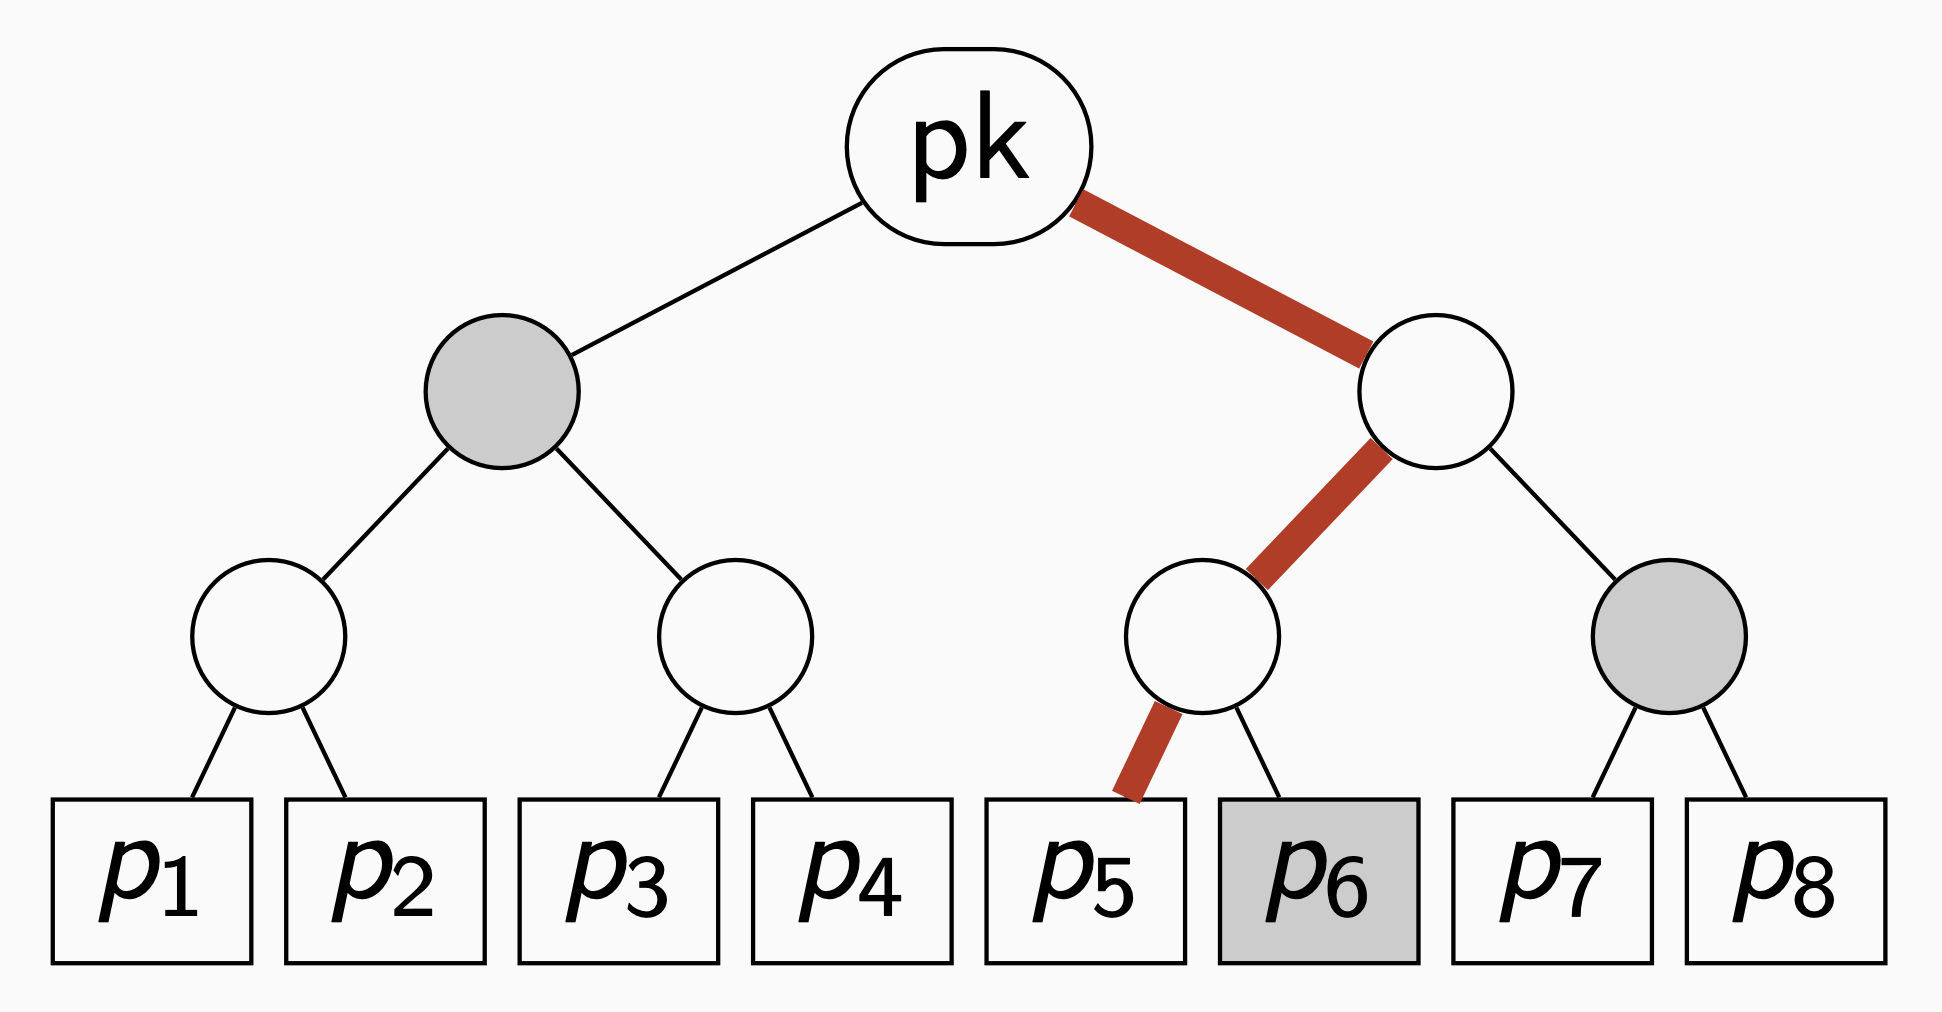



Si queremos poder firmar 128 mensajes con la misma clave pública
1. ¿Qué profundidad tendrá el arbol?
2. ¿Cuantos elemenos tendrá el camino de autenticación?
3. ¿Qué longitud tendrá la firma?




A continuación vamos a implementar una simplificación de LMS/XMSS con una profundidad de $8$. La clave privada consistiría en las 67 cadenas secretas asociadas a cada una de las $2^8$ claves públicas de tipo WOTS, recordad que en WOTS usamos 64 bloques para el mensaje más los 3 del checksum. Para no tener que almacenar $67*(2^8)$ cadenas, usaremos nuevamente una semilla de 32 bytes. Concatenando a esta semilla un byte que represente un número entre 0 y $2^8-1$, y aplicando H, obtendremos la semilla privada asociada a la clave pública de la hoja con el índice del número elegido.

El algoritmo de generación de claves consistirá por tanto en generar las claves públicas WOTS a partir de sus semillas privadas, y luego ir concatenando estas claves y aplicando H sucesivamente hasta llegar a la raíz del árbol. Es importante recordar que las firmas WOTS son de un solo uso, por tanto tenemos que llevar un control de que hojas hemos usado para no repetir. Esta propiedad hace que el algoritmo sea de tipo "Stateful".

A continuación un diagrama con más detalle de un árbol de merkle de profundidad 2 con las firmas WOTS en las hojas del árbol.

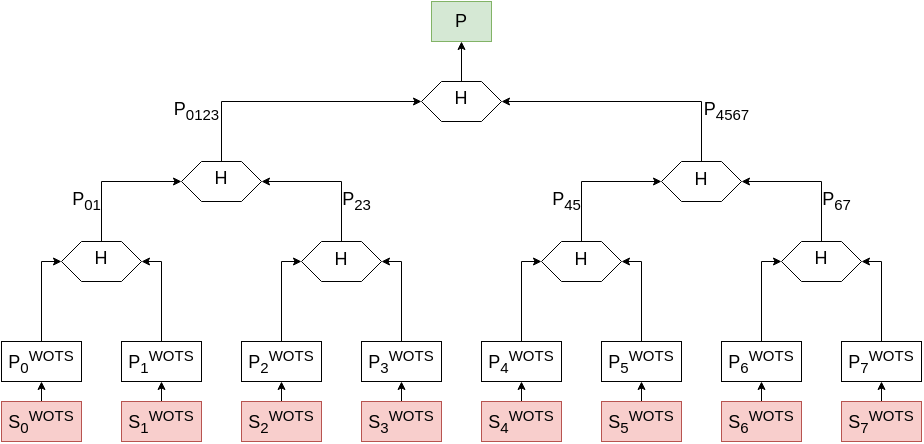

A continuación, la implementación de la generación de claves XMSS y un ejemplo de su uso:

In [ ]:
def xmss_gen():
  sk_seed = bytes(list(np.random.randint(256,size=32)))
  pk = xmss_node(sk_seed,indice=0,altura=8) #El árbol está formado por 2^8 WOTS

  return pk,sk_seed

def xmss_node(sk_seed,indice,altura):
  if altura==0:
    sk_seed_wots = H(sk_seed + indice.to_bytes(length=1,byteorder='big'))
    return wots_pk_from_sk(sk_seed_wots) #pk del WOTS correspondiente
  else:
    left_node = xmss_node(sk_seed,2*indice,altura-1)
    right_node = xmss_node(sk_seed,2*indice+1,altura-1)
    return H(left_node+right_node)

In [ ]:
pk,sk_seed = xmss_gen()
print("pk=",pk.hex())
print("sk_seed=",sk_seed.hex())

pk= c19342a0462a4c2c763dcccc8297607feca5214b84c326b5e8816ebd613822d4
sk_seed= ed1ebc25b374fbd19354e321e1621ffd3a695556ca39fb5c5fca6e1564a40c1b


La firma en este algoritmo consiste en usar un WOTS de una de las hojas y firmar el mensaje con la clave privada asociada. Además, deberemos proporcionar el camino de autenticación, de forma que el verificador pueda obtener la raíz del árbol a partir de la firma y de dicho camino. Veámoslo mejor con un ejemplo:

Imaginemos que en el árbol de altura 3 de la imagen anterior, queremos firmar usando la clave privada asociada a la clave pública $P_4^{WOTS}$. Primero obtendremos la semilla privada de dicha clave mediante la semilla privada del árbol, y firmaremos el mensaje deseado usando el algoritmo ```wots_sign```.

Alguien que desee verificar la firma será capaz de obtener $P_4^{WOTS}$ a partir del mensaje y la firma WOTS. Entonces, en la firma XMSS, habremos de incluir también los valores de los nodos $P_5^{WOTS}$, $P_{45}$ y $P_{4567}$, que serán el camino de autenticación. Esto permitirá al verificador obtener la raíz del árbol, $P$, a partir de $P_4^{WOTS}$ y los 3 nodos del camino de autenticación.

La firma por tanto consistirá en una firma WOTS, y tantos nodos como altura tenga el árbol. Nuestra implementación usa árboles de altura 8, con lo que la longitud de la firma será la suma de la longitud de una firma WOTS (2144 bytes) y de 8 cadenas de 32 bytes, es decir, 2144+8*32=2400 bytes.

Veamos cómo implementar el algoritmo de firma y un ejemplo de su uso:

In [ ]:
def xmss_sign(M,sk_seed,indice):
  #indice: debemos indicar que WOTS usar. 0<=indice<=2^8-1=255
  signature = bytes()
  sk_seed_wots = H(sk_seed + indice.to_bytes(length=1,byteorder='big'))
  signature += wots_sign(M,sk_seed_wots) #Añadimos la firma del mensaje con el WOTS correspondiente

  #Nos falta incluir el camino de autenticación
  for altura in range(8):
    k = indice//(2**altura)
    if k%2 == 0:
      k = k+1
    else:
      k = k-1
    signature += xmss_node(sk_seed,k,altura)

  return signature

Comparamos con el algoritmo del NIST:

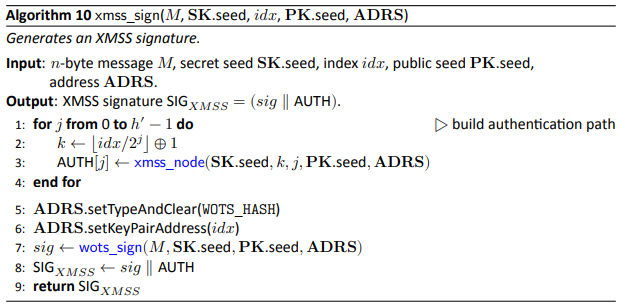

In [ ]:
M = input("Enter the message: ")
indice = int(input("Enter index: "))
signature = xmss_sign(M,sk_seed,indice)
print("Firma: ",signature.hex())
print("Longitud de la firma:",len(signature),"bytes")

Enter the message: adios
Enter index: 4
Firma:  4256e5e3408e6caff76c233d26223baa02b2febeaa49c9ebb629511af8b04b5376d42d0d7337af59337405b65d0f5eea9adc1b867040aa5f027651aedb186930842f3b15a1db276bf38e6d50895413f4e3b4f92b0df997598772de0389d693f98d771f4a5beb0ba2b133481bdd4f000ee1a119da5acd8bfb31f3d447cc39fc833513b49b9287f38ad541de4d60ab8f3786e34493f5e3c249ade26d89790ca0fff2604938d407c559df5afbe9ef46a2b932d74fc36832fa135f3435df122e0df239c9a90c071579a835cdbcbb0e0c15e59cb2e7d1faf6aa5585dabf7ea3784eaa4507c13f33b17a520cd8ff83ebc30c228ccb38d57330e3562ccdc3b4c21e0f2866ecfee29447a19c19dee54fffac79d06da336cccc05fd1ab7020af8055d550fb832efe3d42cb75a1cafdf28b24c85ec1217cbfaccb4af22412a10d0ed80f9acebb5283ec8fe514e0c99028967e092114a76c7e492f0932f313bdfb83d2d306117222d329efa42c6c625a1c6a92894e0396d63f7693dd507ca24c239a3058b731669f4d4776f2d044c89cc6dfa3757e0f6159e6018b86d19ce317c6ed27c18c23c2d979f8d301ce07e7ab535924b61e650cab69d3e8581cec3247fc3329690ef02d23809697700db231a5bc119397458aca941a810bee58b192a39a2

La verificación consiste, como ya hemos visto, en calcular la clave pública del WOTS usado, y conociendo el índice de la hoja a la que pertenece dicha clave pública, así como el camino de autenticación, obtener la que debería ser la raíz del árbol.

Conocer el índice de la hoja usada es importante para saber en qué orden se han de concatenar los nodos del camino de autenticación y la clave pública WOTS.

Finalmente se comprueba si el valor obtenido coincide con la clave pública XMSS, es decir, con la raíz real del árbol.

In [ ]:
def xmss_verify(M,signature,pk,indice):
  pk_candidate_wots = wots_pk_from_signature(M,signature[0:2144])
  authentication_path = signature[2144:2400]
  pk_candidate = pk_candidate_wots
  for altura in range(8):
    k = indice//(2**altura)
    if k%2 == 0:
      pk_candidate = H(pk_candidate + authentication_path[32*altura:32*(altura+1)])
    else:
      pk_candidate = H(authentication_path[32*altura:32*(altura+1)] + pk_candidate)

  return pk_candidate==pk

Más adelante, usaremos XMSS dentro de otro algoritmo, y en ese caso lo que nos interesará es poder obtener una clave pública XMSS a partir de una firma, el mensaje firmado, y el índice de hoja usado.

Basta quitar la comprobación final del algoritmo anterior y la necesidad de pasar la clave pública como parámetro, lo que da lugar a la siguiente variante:

In [ ]:
def xmss_pk_from_signature(M,signature,indice):
  pk_candidate_wots = wots_pk_from_signature(M,signature[0:2144])
  authentication_path = signature[2144:2400]
  pk_candidate = pk_candidate_wots
  for altura in range(8):
    k = indice//(2**altura)
    if k%2 == 0:
      pk_candidate = H(pk_candidate + authentication_path[32*altura:32*(altura+1)])
    else:
      pk_candidate = H(authentication_path[32*altura:32*(altura+1)] + pk_candidate)

  return pk_candidate

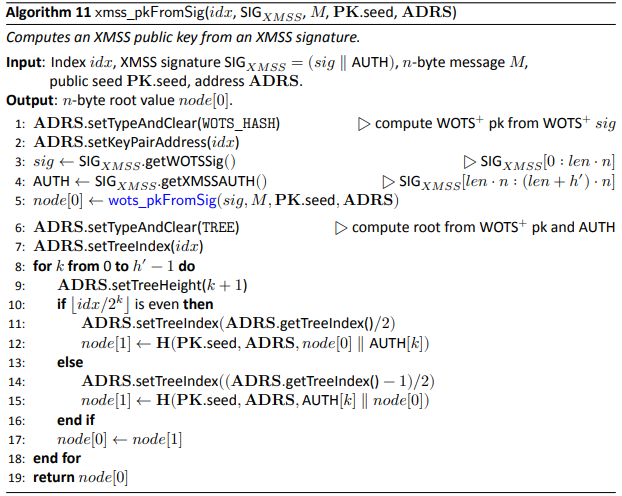

En nuestra implementación, h'=8

In [ ]:
pk = bytes.fromhex(input("Enter public key: "))
M = input("Enter the message: ")
signature = bytes.fromhex(input("Enter signature: "))
indice = int(input("Enter index: "))
ok = xmss_verify(M,signature,pk,indice)
print(ok)

La limitación de tener tener que mantener el estado es más compleja de lo que podríamos pensar:
* Complica el uso de esta firma en sistemas con concurrencia donde un servidor web pueda estar procesando varias conexiones de forma concurrente, ya que habría que encolar las firmas y esperar a terminar una para empezar la siguiente.
* Si hacemos copias de seguridad y restablecemos puede que hayamos hecho algunas firmas desde la copia y el contador esté desactualizado.

1. Comprueba que si se repite el índice puedes falsificar la firma de un mensaje diferente.





Otra actualización que incluyen estos esquemas en el uso de Hyper-Trees. Hierarchical Signature Scheme (HSS) en la versión con Hyper-Trees de LMS. Para ello hay dos capas, en la primera capa tenemos un árbol donde las hojas firmas las raices de los arboles del segundo nivel.

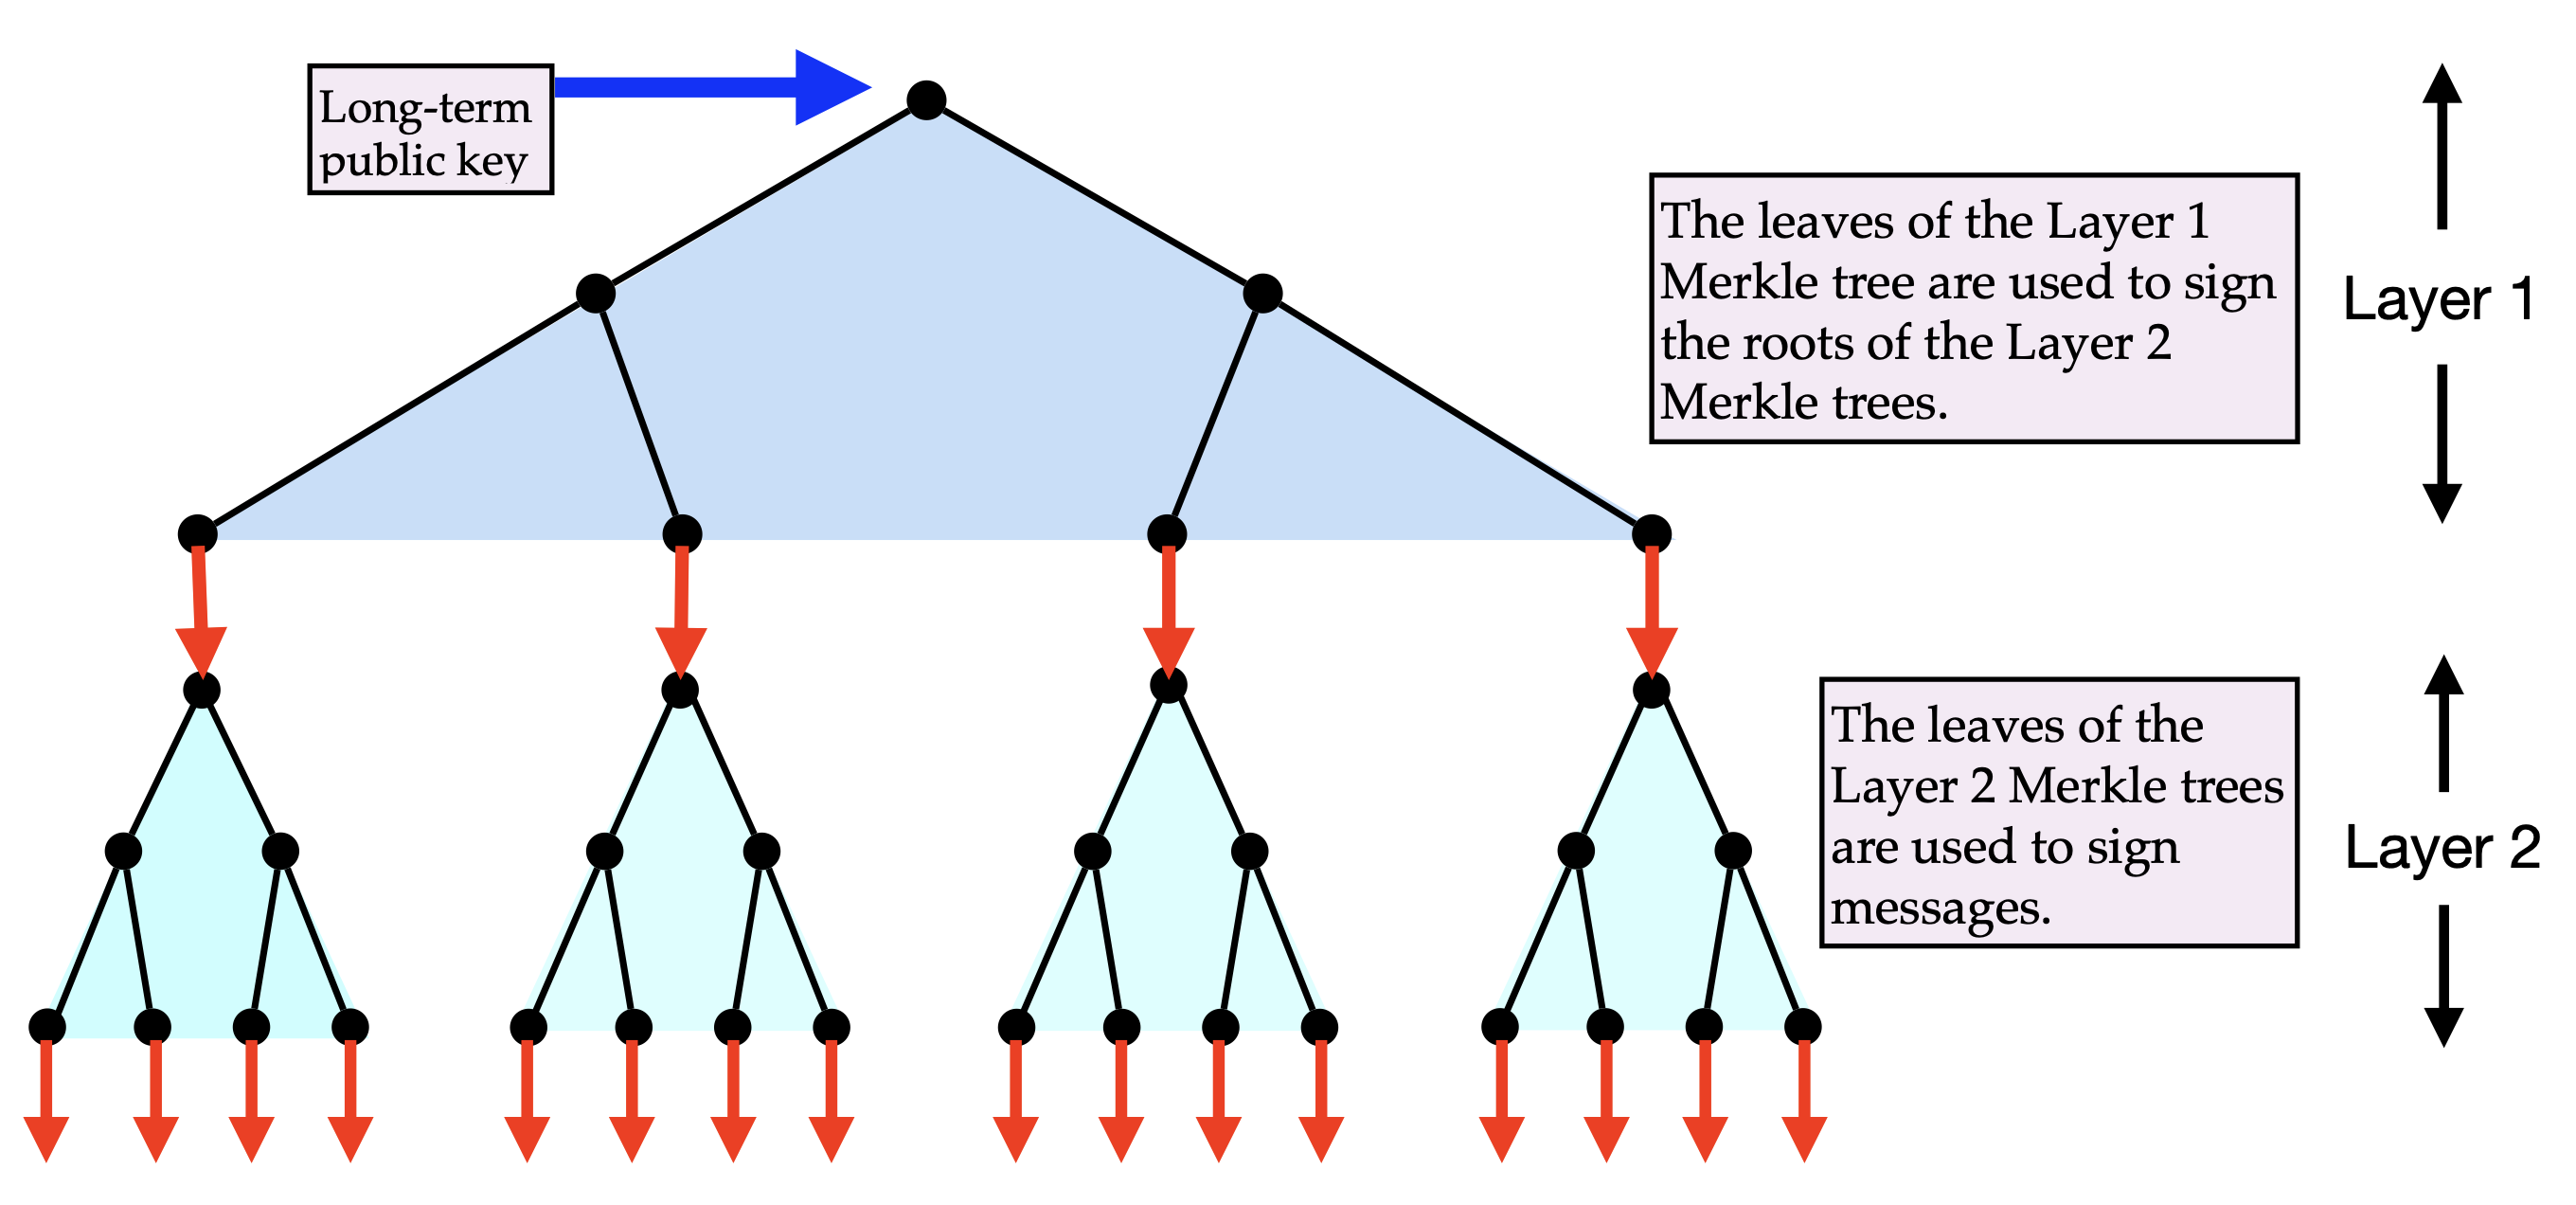

#Forest of Random Subsets (FORS)

El algoritmo FORS (Forest of Random Subsets) resuelve el problema de tener que mantener el estado de una forma muy simple. En lugar de tener que usar un contador para indicar que clave tenemos que utilizar, el propio mensaje que vayamos a firmar nos servirá como índice para elegir la clave. Supongamos que tenemos un mensaje de 3 bits, cada bit, de izquierda a derecha, nos va a indicar que nodo tenemos que publicar en el camino de autenticación: izquierda en caso de un $0$ o derecha en caso de un $1$. También tiene la ventaja de que se puede usar para firmar varios mensajes con la misma clave pública, si bien, cuantas más firmas diferentes se realicen más nodos intermedios se terminarán publicando.

Si quisieramos hacer esto para mensajes de 256 bits tendríamos que hacer un número impracticable de operaciones hash. Aunque solo tengamos que publicar ciertos nodos intermedios en cada firma, hay que tener en cuenta que habría que precalcular el arbol completo para poder obtener el valor de la clave pública.

Una posible solución es usar una aproximación similar a WOTS y romper el mensaje en bloques, de forma que autentiquemos cada bloque de forma indepediente. En el siguiente diagrama se ve como firmar un mensaje $m =$ 100 011 011 101 111 000. La clave pública en ese caso sería $H(r_0, r_1, r_2, r_3, r_4, r_5)$. La firma sería $\sigma = (sk_{4}^{0},auth_{4}^{0},sk_{3}^{1},auth_{3}^{1},sk_{3}^{2},auth_{3}^{2},sk_{5}^{3},auth_{5}^{3},sk_{7}^{4},auth_{7}^{4},sk_{0}^{5},auth_{0}^{5})$

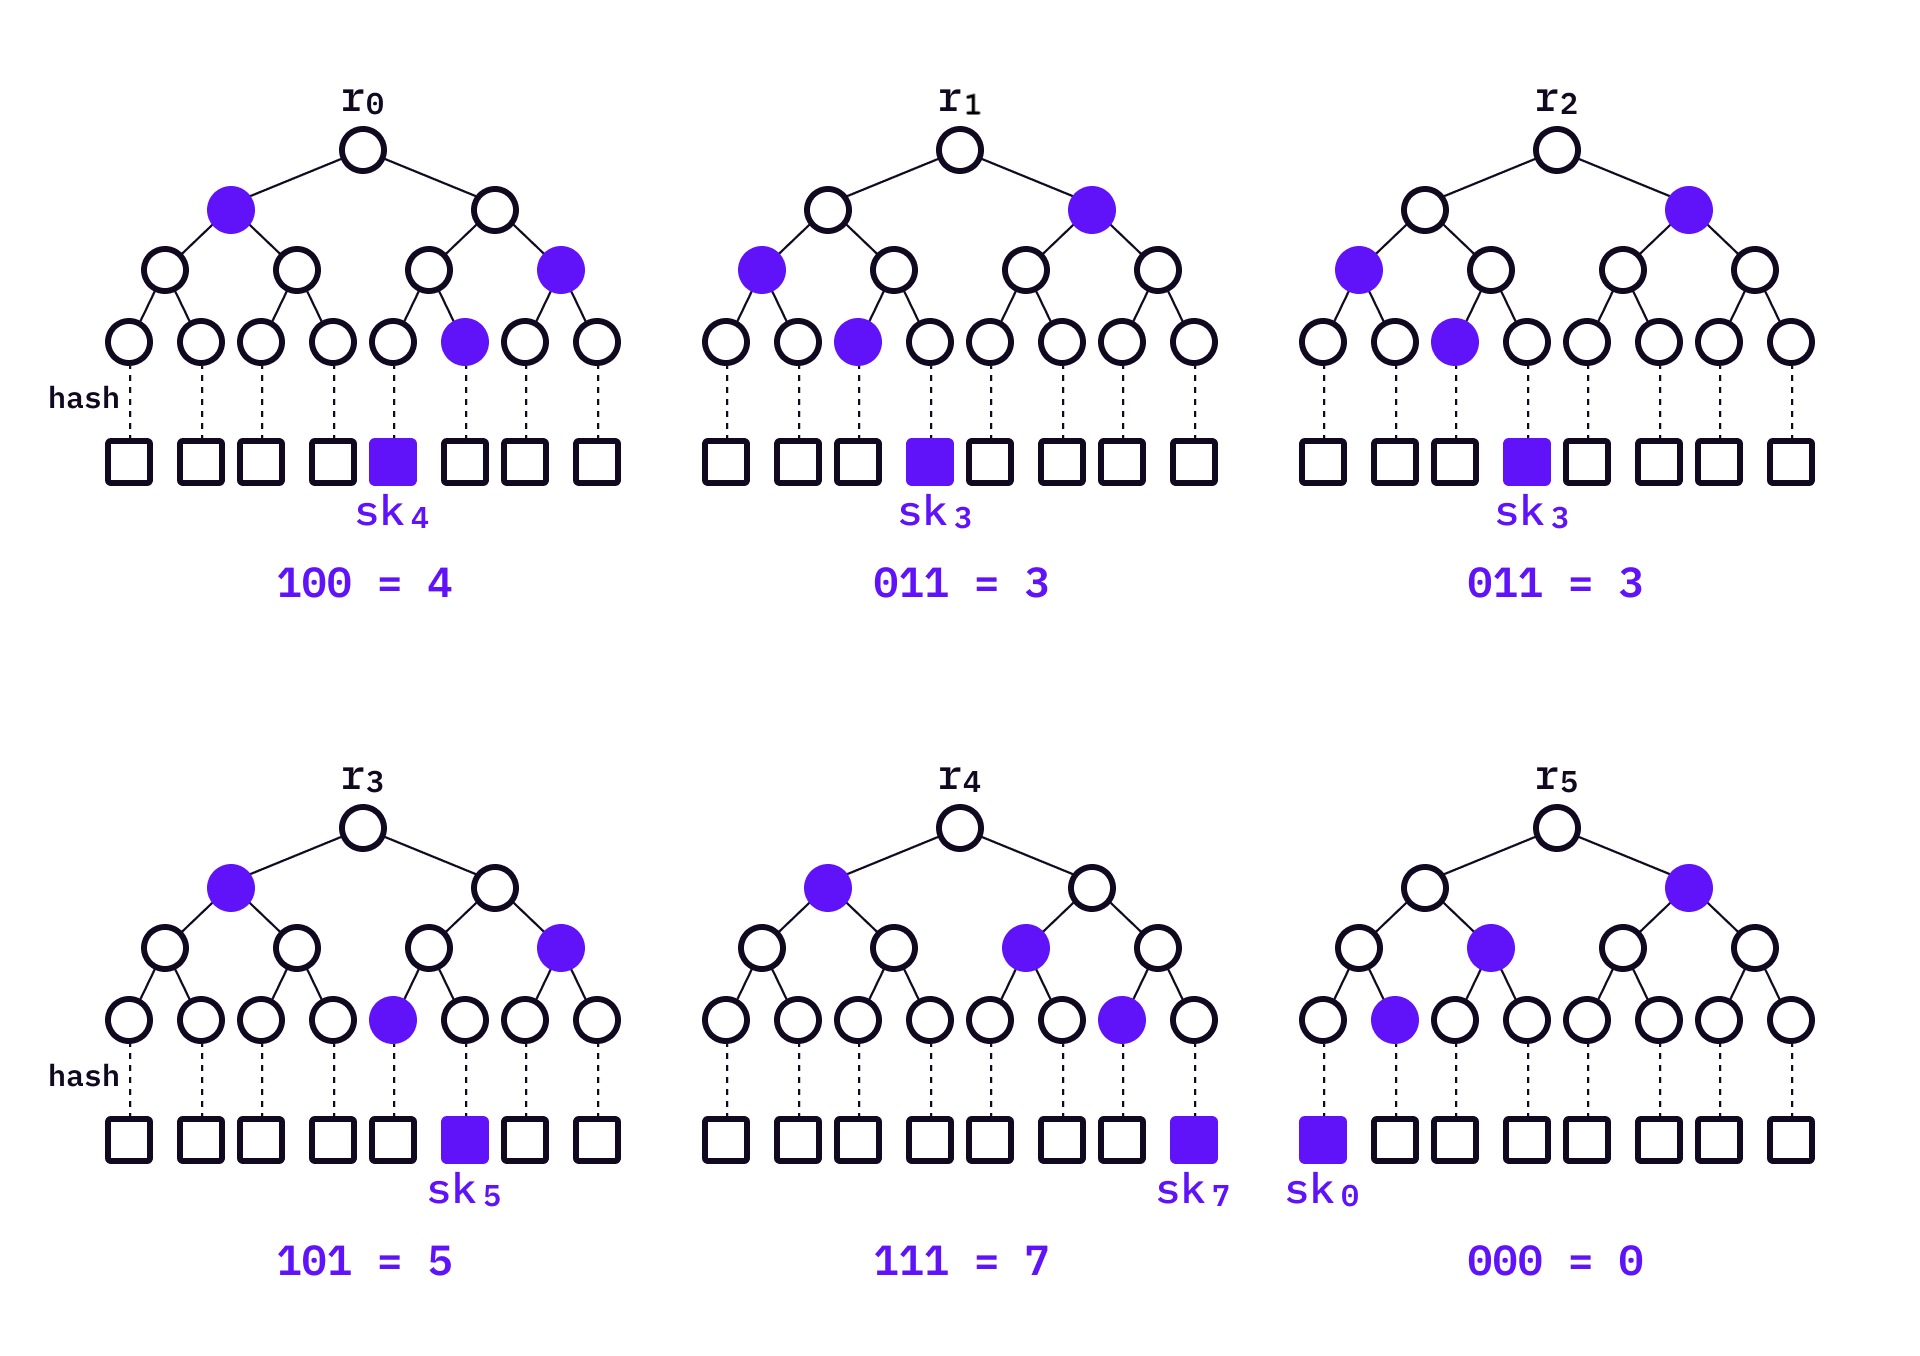

FORS consiste en usar varios árboles de Merkle, en nuestro caso 32 árboles de altura 8 cada uno. Tendremos por tanto $32*2^8$ hojas. En este caso no usaremos WOTS, sino que en cada hoja guardaremos simplemente el valor hash de un vector secreto de 32 bytes.

La clave privada consiste por tanto en $32*2^8$ cadenas de 32 bytes, pero en la práctica se usa nuevamente una semilla, a la que se le concatena un índice entre $0$ y $32*2^8-1$ y se le aplica H para obtener cada una de esas cadenas.

Una vez se calculan las hojas de los árboles, que son los valores hash de las cadenas secretas, obtenemos la raíz de cada árbol de la misma forma que en XMSS. Finalmente, se concatenan todas las raíces y se aplica H para obtener una cadena de 32 bytes, que será la clave pública FORS.

El algoritmo de generación de claves consiste entonces en obtener una semilla aleatoria, obtener las cadenas secretas de 32 bytes a partir de dicha semilla, calcular los valores de las hojas como el hash de las cadenas secretas, y finalmente obtener las raíces de los árboles y la clave pública FORS. En la siguiente celda implementamos dicha generación de claves:

In [ ]:
def fors_gen():
  sk_seed = bytes(list(np.random.randint(256,size=32)))
  pk = bytes()
  for i in range(32): #32 árboles de altura 8, buscamos la raíz de cada árbol
    pk += fors_node(sk_seed,indice=i,altura=8)
  pk = H(pk) #Unimos todas las raíces y les hacemos un hash, esta será la clave pública

  return pk,sk_seed

def fors_node(sk_seed,indice,altura):
  if altura==0:
    secret_bytes = H(sk_seed + indice.to_bytes(length=2,byteorder='big')) #Obtenemos la cadena secreta a partir de sk_seed y el índice de la hoja
    return H(secret_bytes) #Aplicamos el hash a la cadena secreta, el resultado será el valor de la hoja del árbol
  else:
    left_node = fors_node(sk_seed,2*indice,altura-1)
    right_node = fors_node(sk_seed,2*indice+1,altura-1)
    return H(left_node+right_node) #El valor de un nodo intermedio se calcula concatenando a sus hijos y aplicando H

In [ ]:
pk,sk_seed = fors_gen()
print("pk =",pk.hex())
print("sk_seed =",sk_seed.hex())

pk = 586baa46b055e7978da94b3d6949b3326e5fc251952bb0206de6bb3075ad8670
sk_seed = 10f18a99cc4d8cf93faf1cf7337231552bbf35595744564790f2e8d3c601fc4f


La firma en FORS consiste en coger el hash de 32 bytes del mensaje que queremos firmar, representarlo como 256 bits, y dividir dichos bits en 32 grupos de 8 bits. Cada grupo de 8 bits nos dice que cadena secreta tenemos que publicar de cada árbol. Por ejemplo, si el primer grupo de 8 bits representa el número 130, publicaremos la cadena secreta número 130 del primer árbol.

Por tanto tendremos que publicar 32 cadenas secretas, una de cada árbol.

Además, para cada árbol tendremos que publicar el camino de autenticación asociado a la hoja correspondiente a la cadena secreta publicada. Tendremos por tanto otras 8 cadenas que publicar para cada uno de los 32 árboles.

Como resultado, tenemos que publicar $32*(8+1)$ cadenas de $32$ bytes cada una, luego la firma tendrá longitud $32*9*32=9216$ bytes.

El orden que seguiremos será publicar primero la cadena secreta del primer árbol, luego el camino de autenticación de dicho árbol, y luego hacer lo mismo con el resto de árboles.

Una vez explicada la forma en la que se firma un mensaje, se puede observar que en este esquema no necesitamos indicar los índices de los valores secretos a publicar, pues estos vienen dados por el mensaje a firmar. Aun así, este esquema también permite firmar más de un mensaje, reduciéndose la seguridad del esquema conforme más firmas hagamos (cuantos más valores secretos se publiquen más fácil será encontrar un mensaje no firmado anteriormente del que conozcamos todos los valores secretos que se han de publicar para realizar su firma). Debido a que no necesitamos controlar qué índices hemos usado ya para firmar, se dice que el esquema es de tipo "Stateless".

In [ ]:
def fors_sign(M,sk_seed):
  signature = bytes()
  if isinstance(M, bytes):
    msg = M
  else:
    msg = H(M.encode("utf-8"))

  for i in range(32): #Para cada uno de los 32 árboles, calculamos la hoja a publicar junto con el authentication path
    indice = 256*i+msg[i]
    signature += H(sk_seed + indice.to_bytes(length=2,byteorder='big'))

    for altura in range(8):
      k = indice//(2**altura)
      if k%2 == 0:
        k = k+1
      else:
        k = k-1
      signature += fors_node(sk_seed,k,altura)

  return signature

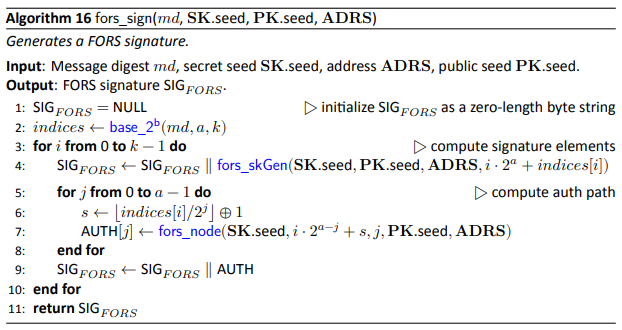

In [ ]:
M = input("Enter the message: ")
signature = fors_sign(M,sk_seed)
print("Firma: ")
print(signature.hex())
print("Longitud de la firma:",len(signature),"bytes")

Enter the message: hola
Firma: 
f243f96d531b5d13a3fb8547e9fc96d875e9a29806d1409afb1f536b155a43ef683298f6dc053d3222bbd55af17efd4e675f4616011960215066f14cf63242fa8e4de64f4c7f534877bfece00adcfca3a667aae780b03e99a1fbb3adc147813c31a74149abc69d5c4e0e205ae983b9616ca99185c6e7007cccd5c9f0a51a327cbf47a70c813bf7104f1af2322eced54403eb5862b0df7ed5ba3eed675c76e5f2e0f017f8f4bddd6e5b806cd3ed8afdd1fabf5f22707a013e32edc1811ca976c180594335e025c60a169732eac06d2dfdd267c3f376501bd584efc7e64b0411e52be33a42dc932f4bc1bc6ea39580be3df0d676ba62906b86352ab232979a83c48a6ec0c93c7f5c1df82debdfb5c3ca9c35c0beaaa49268499075fd8bf5afbd4459a491bf324f37931b05b088f10d6d1815e00e5e34965c309d0c437f9411a74416d272dc2d529f3111a7d57822588f5d40455ed252ba18b0552725a6914a1e6699ee861c09c4a83a1a6876a4f1ba206d6b078df9a5fcb28774192dc9dfebf95a8be8ef35365c05afefe3ee674d5d603f12592b9fc8c29819b3905fe9f55cd7f1700db0ec906910feeeeb5aa575b384a3f187f0a435e4eb017cd1ddac24bbba9344337a3b7c42733d238f30aa9fb0b2f583ceb8868cce063c4de7e39817bb7f0e1e0e3049

Para verificar una firma, obtendremos la raíz de cada árbol a partir de las cadenas secretas y los caminos de autenticación. Finalmente, concatenamos todas las raíces y aplicamos la función hash H, tras lo cual comprobamos que el valor obtenido coincide con la clave pública FORS.

In [ ]:
def fors_verify(M,signature,pk):
  if isinstance(M, bytes):
    msg = M
  else:
    msg = H(M.encode("utf-8"))
  pk_candidate = bytes()

  for i in range(32): #Para cada uno de los 32 árboles, calculamos la hoja publicada y usando el authentication path reconstruimos la raíz de cada árbol
    indice = 256*i+msg[i]
    tree_root = H(signature[32*9*i:32*9*i+32])
    authentication_path = signature[32*9*i+32:32*9*(i+1)]

    for altura in range(8):
      k = indice//(2**altura)
      if k%2 == 0:
        tree_root = H(tree_root + authentication_path[32*altura:32*(altura+1)])
      else:
        tree_root = H(authentication_path[32*altura:32*(altura+1)] + tree_root)

    pk_candidate += tree_root #Añadimos la raíz del árbol

  pk_candidate = H(pk_candidate) #Unificamos todas las raíces para obtener la candidata a clave pública

  return pk_candidate == pk #Verificamos que la firma es correcta

Nuevamente tendremos una variante en la que simplemente devolvemos el valor que debería ser la clave pública en caso de que la firma sea correcta:

In [ ]:
def fors_pk_from_signature(M,signature):
  if isinstance(M, bytes):
    msg = M
  else:
    msg = H(M.encode("utf-8"))
  pk_candidate = bytes()

  for i in range(32): #Para cada uno de los 32 árboles, calculamos la hoja publicada y usando el authentication path reconstruimos la raíz de cada árbol
    indice = 256*i+msg[i]
    tree_root = H(signature[32*9*i:32*9*i+32])
    authentication_path = signature[32*9*i+32:32*9*(i+1)]

    for altura in range(8):
      k = indice//(2**altura)
      if k%2 == 0:
        tree_root = H(tree_root + authentication_path[32*altura:32*(altura+1)])
      else:
        tree_root = H(authentication_path[32*altura:32*(altura+1)] + tree_root)

    pk_candidate += tree_root #Añadimos la raíz del árbol

  pk_candidate = H(pk_candidate) #Unificamos todas las raíces para obtener la candidata a clave pública

  return pk_candidate

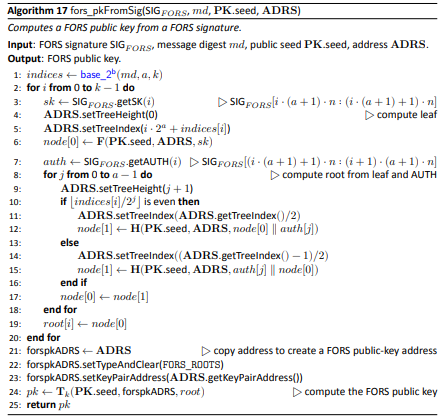

In [ ]:
pk = bytes.fromhex(input("Enter public key: "))
M = input("Enter the message: ")
signature = bytes.fromhex(input("Enter signature: "))
ok = fors_verify(M,signature,pk)
print(ok)

Enter public key: 61016b37181acfcc1ccd8669e369c511fe2a654ab4f3715a3e5de5b4e10c2f9e
Enter the message: hole
Enter signature: 1a2aa3a8a55358ee20a926386b24a74ef182c81600f84e1a9f165752aa570667e791b98dba22a68790b9ad5937d8a03212397da31a92653523279de5bfd9748100da2e63464e9a7814e92e4556cd6c03f6ab1e7dc1bd03e510e26985b2c5b5dc8675f402fd31305750505f20ace67e8059e095082137421af16b51aad0acd5028ecedd9f6d3d721e3e5f2d1092ec6884e168383308c7ba2edbdc280e5a88e525ff9c04911f8034986b304cb92c4ce697a1c0c26fb90d49a1e0d67b383870af8379a6af65107735ec0ff47098ee3aaecdb811db22a107780a9e8d9536215c9a56e47a4c3ef80c706e26044b6087c5e3c7310b9b69a779d9e2f1256f73be0909bee389ae9b55f1bbefab03ace3922245cabe2814d7d5035a7c864395dcb56a5e8be3cc609f52122be2fbcea74f2620fbf9027db9fa39fa5a029d03f68a1a9fb5e5c5daf42c4a25695ebd5d12ecf18768394dbe0df7abb873d0f7715c75806d393a63a8a5d8a52fbc553a8c28fa7ea60a925da7df21082c2eb27af28ca863d14fc63c725edee77ffe0d8520b2568a111d86f66a83161578e3593ec871b8171d99dd4cafb51daafd5b9f986329649ca6f04050ceb675959a

Es importante que en FORS se firme el Hash del mensaje y no el mensaje directamente.

* ¿Podrías indicar porqué es tan crítico esto?

* ¿Puedes encontrar una forma de falsificar firmas si no se hace el hash al mensaje antes de realizar la firma?

* Si usas el hash, ¿Puedes hacer una simulación de cuantos intentos habría que hacer para poder falsificar una firma?

#SPHINCS+

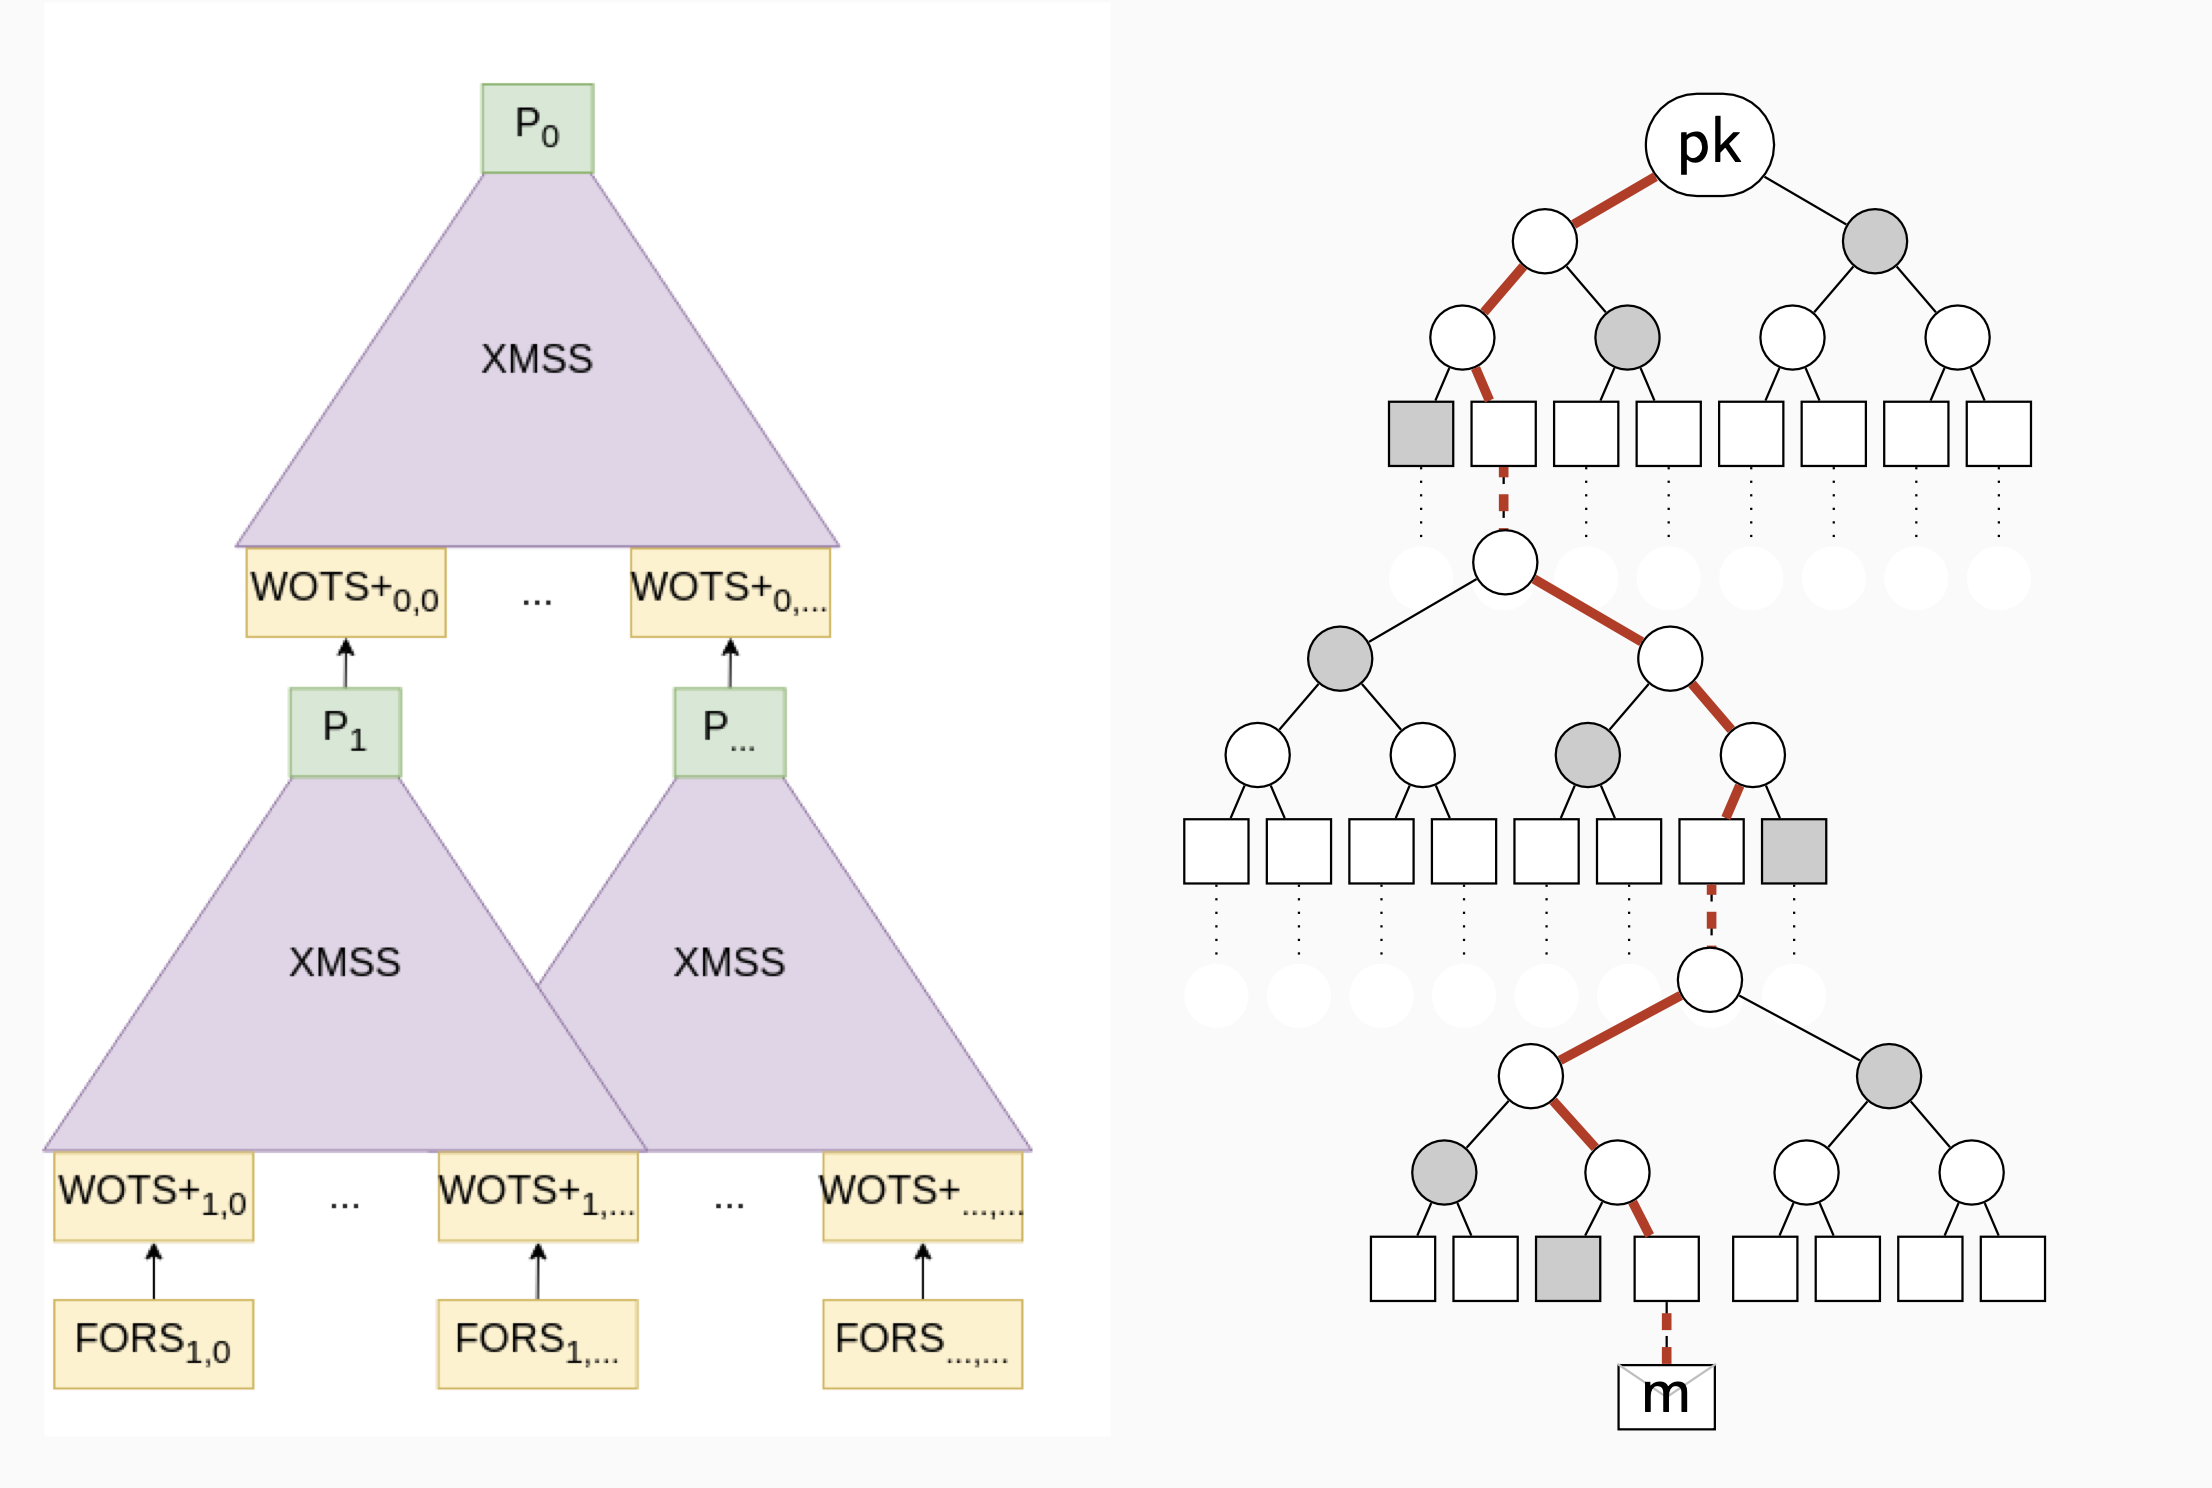

## Stateful version

Veamos ahora cómo funciona el algoritmo SPHINCS+ primero con una versión donde sigue tiendo que haber un control de los indices que ya hemos usado para firmar. La principal novedad con respecto a lo que hemos visto hasta ahora es el uso de **Hypertree**.

En este algoritmo, crearemos un árbol de árboles.
Tendremos un árbol XMSS principal, con $2^8$ claves WOTS. Estas claves WOTS se usarán para firmar $2^8$ claves públicas XMSS.
Cada una de estas $2^8$ claves públicas XMSS tendrá asociadas otras $2^8$ claves WOTS, dando un total de $2^{16}$ claves WOTS. Nuevamente, usaremos estas claves WOTS para firmar $2^{16}$ claves públicas XMSS.
Continuaremos de esta forma hasta llegar a tener $2^{56}$ claves públicas XMSS, y por tanto $2^{64}$ claves WOTS. Estas claves WOTS son las que se encargarán de firmar los mensajes, y solo podremos usar cada una de ellas una vez.

La clave pública del hiperárbol será la clave pública del árbol principal. La clave secreta consistirá de las semillas secretas de cada árbol, incluyendo el principal, los árboles intermedios (6 capas de árboles intermedios, con $2^{8i}$ árboles en la capa $i$), y los árboles de la última capa (se pueden ver como las hojas del hiperárbol, un total de $2^{56}$). Nuevamente, todas estas semillas se extraerán de una única semilla principal, a la que se concatenará la capa o altura del hiperárbol e índice del árbol elegido en esa capa para obtener la semilla secreta XMSS que deseemos.

En el algoritmo de generación de claves, solo tenemos que generar la semilla secreta principal, y la clave pública del árbol principal, que es la clave pública del hiperárbol.

In [ ]:
def ht_gen():
  sk_seed = bytes(list(np.random.randint(256,size=32)))
  indice = 0
  altura = 7
  sk_seed_top_tree = H(sk_seed + altura.to_bytes(length=1,byteorder='big') + indice.to_bytes(length=7,byteorder='big'))
  pk = xmss_node(sk_seed_top_tree,indice=0,altura=8)

  return pk,sk_seed

Tendremos una variante en la que ya especificamos la semilla secreta y obtenemos sólo la clave pública:

In [ ]:
def ht_pk_from_sk(sk_seed):
  indice = 0
  altura = 7
  sk_seed_top_tree = H(sk_seed + altura.to_bytes(length=1,byteorder='big') + indice.to_bytes(length=7,byteorder='big'))
  pk = xmss_node(sk_seed_top_tree,indice=0,altura=8)

  return pk

In [ ]:
pk,sk_seed = ht_gen()
print("pk =",pk.hex())
print("sk_seed =",sk_seed.hex())

pk = a116194b650011185d8b2e178771f899a422b9a9d1b65773e217c9db09d34d09
sk_seed = c1628a68112ee7fb45fccc2b0fd9a3e7ef6091c92fe9a4dd5effb68aded79243


Para firmar, tendremos que especificar primero cuál de los $2^{56}$ árboles "hoja" vamos a usar, y dentro de ese árbol, qué hoja elegimos para usar la clave WOTS asociada.

Por ello, tenemos que especificar el mensaje, la clave secreta, el índice del árbol (56 bits) y el índice de la hoja del árbol elegido (8 bits).

A continuación, obtendremos la semilla secreta del árbol elegido a partir de la semilla del hiperárbol y del índice del árbol, y firmaremos el mensaje especificando el índice de hoja. Dicha firma formará parte de la firma final.

A continuación, calculamos la clave pública del árbol utilizado para firmar a partir de la propia firma, y firmamos la clave pública con el árbol de la capa superior al que pertenece el ya utilizado. Añadimos esta nueva firma a nuestra firma final.

Continuamos firmando la clave pública del árbol utilizado por el árbol de la capa superior al que pertenece, añadiendo dichas firmas a la firma final, hasta llegar al árbol principal, con el que firmaremos por última vez.

La firma consistirá por tanto de 8 firmas XMSS, la primera es la asociada al mensaje original, y el resto son firmas de las claves públicas XMSS involucradas. La longitud de la firma será la de una firma XMSS 8 veces, es decir, $2400*8=19200$ bytes.

In [ ]:
def ht_sign(M,sk_seed,indice_arbol,indice_hoja):
  #índice árbol es un número entre 0 y 2^56-1
  #índice hoja es un número entre 0 y 255
  #En total tenemos 2^64 WOTS con los que firmar
  signature = bytes()

  altura = 0
  sig_temp = xmss_sign(M,H(sk_seed + altura.to_bytes(length=1,byteorder='big') + indice_arbol.to_bytes(length=7,byteorder='big')),indice_hoja)
  signature += sig_temp
  root = xmss_pk_from_signature(M,sig_temp,indice_hoja)

  for j in range(1,8):
    indice_hoja = indice_arbol%256
    indice_arbol = indice_arbol//256
    altura = j

    sig_temp = xmss_sign(root,H(sk_seed + altura.to_bytes(length=1,byteorder='big') + indice_arbol.to_bytes(length=7,byteorder='big')),indice_hoja)
    signature += sig_temp

    if j<7:
      root = xmss_pk_from_signature(root,sig_temp,indice_hoja)

  return signature

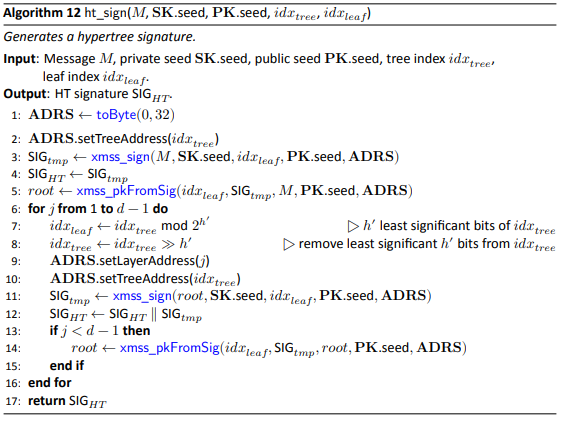

In [ ]:
signature = ht_sign("hola",sk_seed,123456,255)
print("Firma: ",signature.hex())
print("Longitud de la firma:",len(signature),"bytes")

Firma:  54a44182c723b26550b6ac0a111783a35a84618cdb429779158c47600cd3c7688d19cf0b197d174ab3d692d16b26496920505bb8fcf7621083bedce41da29d23ccd233c32661fdf43ae5174cb2e2f26f0232cf36334c8293f17710a671f0ab8a4acfa92b7e4724e5ea5b0e6daeb60134a5f438e07a7ae05e7bfb763743ebae8483113484a4a17fa3e670a07a8557da9bbe5d847b885c3040afd271bf9a237f11297255559ef17d18a5a450d44cd4439a5ccea42d8c4bc831923f65754bdb1bdb8fb80489cd0b20c6cdba3eb763d61b430f632a97fcc8b857bb7d9f70f45a1868fedf515e9e4cb4f48b33b3a82bc327c18df8b09721c71a085305eb9ef8313ba94fd945c46d86b554ab81aaaa3745df54577774e9f15c58e1d68d22dedce723e303a02f05d715ab56f4e8980d8e6980ba31a52c26c6394dd00df256f0310e4f8f6e3f040e4f9cfe716ca4e7767542a308cb20bf417b8df99c62902508625ca54447e9c66c2a0f9cfe70d35fc112ea44f35787ef2048b410b3dd70c71a8bba8f553b272cb53f3c4c3557edb90fa19566c539d98c405da8d2f5bc4e45f24b03cf69b9109f8328f14d40a6cb2cf569f98f035829cec5b50eba89d87a2ab9286693358e6a03a6a8d73dec27014f2c34dcc0e5c97e79450dcbe74f47e8837d7e86e8da20531d549a4c30095708082c6eb6881a

Para verificar una firma, usaremos la primera firma XMSS y el mensaje para obtener la clave pública XMSS del árbol de la capa inferior utilizado. A continuación, usaremos dicha clave pública y la segunda firma para obtener la clave pública del árbol de la penúltima capa utilizado. Seguiremos así hasta llegar a lo que debería ser la clave pública del árbol principal. Sólo tendremos que comprobar que el valor obtenido realmente es dicha clave pública.

In [ ]:
def ht_verify(M,signature,pk,indice_arbol,indice_hoja):
  sig_temp = signature[0:2400]
  node = xmss_pk_from_signature(M, sig_temp, indice_hoja)

  for j in range(1,8):
    indice_hoja = indice_arbol%256
    indice_arbol = indice_arbol//256
    altura = j

    sig_temp = signature[2400*j:2400*(j+1)]
    node = xmss_pk_from_signature(node,sig_temp,indice_hoja)

  return node==pk

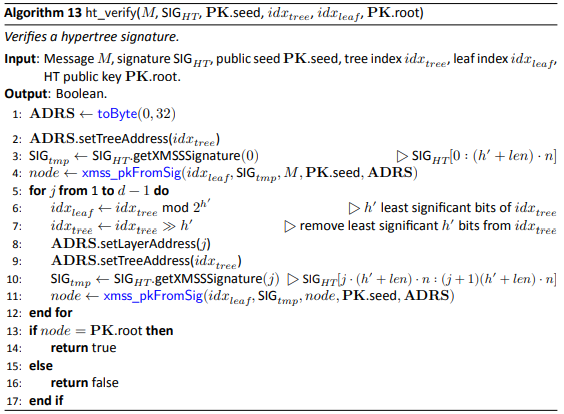

In [ ]:
M = "hola"
indice_arbol=123456
indice_hoja=255
print("Mensaje a firmar:",M)
signature = ht_sign(M,sk_seed,indice_arbol,indice_hoja)
print("Firma del mensaje:",signature.hex())
print("¿Es válida la firma para el mensaje \"",M,"\" ?:",ht_verify(M,signature,pk,indice_arbol,indice_hoja))
Mprima = "adios"
print("¿Es válida la firma para el mensaje \"",Mprima,"\" ?:",ht_verify(Mprima,signature,pk,indice_arbol,indice_hoja))

Mensaje a firmar: hola
Firma del mensaje: 54a44182c723b26550b6ac0a111783a35a84618cdb429779158c47600cd3c7688d19cf0b197d174ab3d692d16b26496920505bb8fcf7621083bedce41da29d23ccd233c32661fdf43ae5174cb2e2f26f0232cf36334c8293f17710a671f0ab8a4acfa92b7e4724e5ea5b0e6daeb60134a5f438e07a7ae05e7bfb763743ebae8483113484a4a17fa3e670a07a8557da9bbe5d847b885c3040afd271bf9a237f11297255559ef17d18a5a450d44cd4439a5ccea42d8c4bc831923f65754bdb1bdb8fb80489cd0b20c6cdba3eb763d61b430f632a97fcc8b857bb7d9f70f45a1868fedf515e9e4cb4f48b33b3a82bc327c18df8b09721c71a085305eb9ef8313ba94fd945c46d86b554ab81aaaa3745df54577774e9f15c58e1d68d22dedce723e303a02f05d715ab56f4e8980d8e6980ba31a52c26c6394dd00df256f0310e4f8f6e3f040e4f9cfe716ca4e7767542a308cb20bf417b8df99c62902508625ca54447e9c66c2a0f9cfe70d35fc112ea44f35787ef2048b410b3dd70c71a8bba8f553b272cb53f3c4c3557edb90fa19566c539d98c405da8d2f5bc4e45f24b03cf69b9109f8328f14d40a6cb2cf569f98f035829cec5b50eba89d87a2ab9286693358e6a03a6a8d73dec27014f2c34dcc0e5c97e79450dcbe74f47e8837d7e86e8

Podemos observar que en este algoritmo tenemos una cantidad mucho mayor de mensajes que podemos firmar con respecto a XMSS, pero nuevamente necesitamos controlar los índices usados para firmar.

## Stateless version (FORS based)

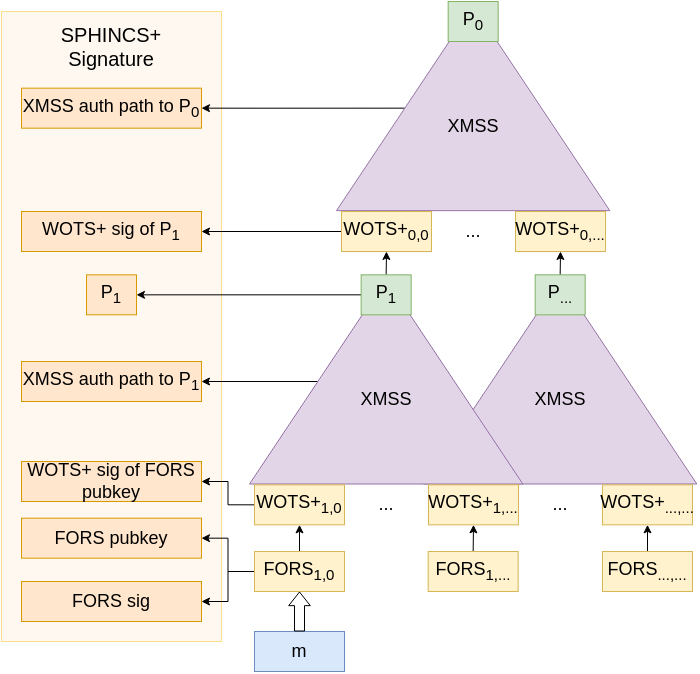

Finalmente, veamos cómo funciona el algoritmo SPHINCS+.
Para ello necesitaremos una función hash cuyas salidas sean más largas. Utilizaremos en concreto salidas de 40 bytes.

In [ ]:
def J(B):
  hash_obj = hashlib.shake_256()
  hash_obj.update(B)
  hash = hash_obj.digest(40)
  return hash

In [ ]:
print(J(b"hola").hex())

8ef8930b87d455f74617ba90ab3b621d8fe8de20ea6564a932d437e69cc48376b686eab6c2c360f9


La idea de SPHINCS+ es usar un hiperárbol como el de SPHINCS+ Hypertree. Sin embargo, en vez de usar las $2^{64}$ claves WOTS para firmar directamente mensajes, se usan para firmar $2^{64}$ claves públicas FORS. Cada clave FORS estará asociada a una clave WOTS, es decir, siempre firmaremos una clave pública FORS con la misma clave WOTS.

La clave pública SPHINCS+ será, como en el algoritmo anterior, la clave pública del hiperárbol. Los valores secretos serán los mismos valores secretos que teníamos en el hiperárbol, añadiendo además las semillas de cada una de las $2^{64}$ claves FORS. Usaremos una semilla principal, a partir de la cual obtendremos la semilla del hiperárbol concatenando a dicha semilla la cadena "HT" y aplicando H. Las semillas FORS se obtendrán concatenando a la semilla principal la cadena "FORS" y los 8 bits que identifiquen qué clave FORS estamos usando.

La generación de claves consistirá en crear la semilla principal, y en calcular la clave pública del hiperárbol, que será la clave pública SPHINCS+ también.

In [ ]:
def slh_gen():
  sk_seed = bytes(list(np.random.randint(256,size=32)))
  pk = ht_pk_from_sk(H(sk_seed + b"HT"))

  return pk,sk_seed

In [ ]:
pk,sk_seed = slh_gen()
print("pk =",pk.hex())
print("sk_seed =",sk_seed.hex())

pk = 77401c4471a7d957584204221e82a32c054ec2e0e482f43aa5be721eabbeeae5
sk_seed = ecb350ccd64870cc00ee3647e40918c7e39db6a5ee155658b8e62fd592e500ae


Para firmar un mensaje, primero obtendremos 40 bytes a partir de este mediante la nueva función hash J.
Los primeros 7 bytes, es decir, 56 bits, nos dirán que árbol hoja del hiperárbol utilizar.
El octavo byte, compuesto por 8 bits, nos dirán que hoja usar dentro del árbol seleccionado anteriormente.
Estos primeros 8 bytes asímismo determinan cuál de las $2^{64}$ claves FORS utilizar.
Finalmente, los últimos 32 bytes, es decir, 256 bits, serán los que realmente firmemos con la clave FORS elegida.
Además, firmaremos la clave pública FORS con el hiperárbol, indicando como árbol y hoja elegidos anteriormente mediante los primeros 8 bytes del hash.

La firma final es por tanto una firma FORS y otra firma del hiperárbol.
La longitud de la firma es por tanto de $9216+19200=28416$ bytes.



In [ ]:
def slh_sign(M,sk_seed):
  signature = bytes()
  msg = J(M.encode("utf-8"))

  indice_arbol = int.from_bytes(msg[0:7], byteorder='big')
  indice_hoja = msg[8]
  sk_seed_fors = H(sk_seed + b"FORS" + msg[0:8])

  sig_fors = fors_sign(msg[8:40],sk_seed_fors)
  signature += sig_fors

  pk_fors = fors_pk_from_signature(msg[8:40], sig_fors)

  sig_ht = ht_sign(pk_fors,H(sk_seed + b"HT"),indice_arbol,indice_hoja)
  signature += sig_ht

  return signature

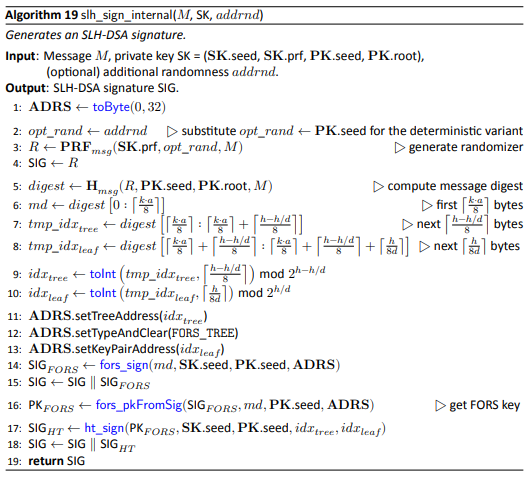

In [ ]:
signature = slh_sign("hola",sk_seed)
print("Firma: ",signature.hex())
print("Longitud de la firma:",len(signature),"bytes")

Firma:  1355f46b1e826010de8a95f3605766df006dbc65942c424eab6664f2e2c7b9a852e1f3166a5c74b809bcd29a72b1bb23d4997b5b2f94ee775336252a77f752c697cadacb69a856cd49500be02aa8499127b4e83294153fce5cd526afc4187ea3d395ef553dc6277a9b63ac343a68335ea73533decb4f493161a81052ba64ce6f1b2cba88df5b748637ca5437f3db402aa569341ec8f4c7df3d279811eb65f8896363f5a9344769b3295e9121757c46105e599f8fdd6dd747d19719a3040a7ce240f4a055b70bc46d95e1471f813ae95784ba74aa5f8a9c7e592340b31f8290cec5e63d5ef1186b063e902621319e53ab9fc5f6866ecef44c57c75eae3d99628578b090b8dc2e21519616445e244b62d99533d93bc7433c5837ec1a432f38f6da5157a103dddd956f2fdbaa482263e3908196c71fe93ac89de5e0fa8a5d7bad8c98de9529b634d8cf6bcea3717eafc907327c5ed37631b2c45eca18ead7d22304b65cead9312e6f73a6a8357ae0d7d730d903892d7cf83443cbf95b66622d1cf6a42895dbda2a73a70ea51ffc76d8e4a0665f0222d09bcb4822bb8b136504ef9f3743ddaf81d47a29ce6db5a9472e6dee0eb19591fd433471c8613430cd60970e504950e6ed8956c60e19a533d39af2f47565d8af86f4d20ebc2791439f091ecdef98080b39310e07729e1de4dda928dc

Para verificar que la firma es correcta, obtenemos la clave pública FORS a partir del mensaje y la firma FORS, y a continuación usamos ht_verify para verificar que la firma del hiperárbol corresponde realmente a la firma de la clave pública FORS obtenida.

In [ ]:
def slh_verify(M,signature,pk):
  msg = J(M.encode("utf-8"))

  indice_arbol = int.from_bytes(msg[0:7], byteorder='big')
  indice_hoja = msg[8]

  pk_fors = fors_pk_from_signature(msg[8:40],signature[0:9216])
  return ht_verify(pk_fors,signature[9216:28416],pk,indice_arbol,indice_hoja)

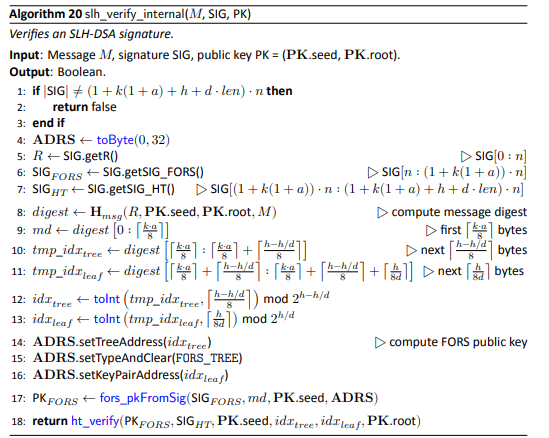

In [ ]:
M = "hola"
print("Mensaje a firmar:",M)
signature = slh_sign(M,sk_seed)
print("Firma del mensaje:",signature.hex())
print("¿Es válida la firma para el mensaje \"",M,"\" ?:",slh_verify(M,signature,pk))
Mprima = "adios"
print("¿Es válida la firma para el mensaje \"",Mprima,"\" ?:",slh_verify(Mprima,signature,pk))

Mensaje a firmar: hola
Firma del mensaje: 1355f46b1e826010de8a95f3605766df006dbc65942c424eab6664f2e2c7b9a852e1f3166a5c74b809bcd29a72b1bb23d4997b5b2f94ee775336252a77f752c697cadacb69a856cd49500be02aa8499127b4e83294153fce5cd526afc4187ea3d395ef553dc6277a9b63ac343a68335ea73533decb4f493161a81052ba64ce6f1b2cba88df5b748637ca5437f3db402aa569341ec8f4c7df3d279811eb65f8896363f5a9344769b3295e9121757c46105e599f8fdd6dd747d19719a3040a7ce240f4a055b70bc46d95e1471f813ae95784ba74aa5f8a9c7e592340b31f8290cec5e63d5ef1186b063e902621319e53ab9fc5f6866ecef44c57c75eae3d99628578b090b8dc2e21519616445e244b62d99533d93bc7433c5837ec1a432f38f6da5157a103dddd956f2fdbaa482263e3908196c71fe93ac89de5e0fa8a5d7bad8c98de9529b634d8cf6bcea3717eafc907327c5ed37631b2c45eca18ead7d22304b65cead9312e6f73a6a8357ae0d7d730d903892d7cf83443cbf95b66622d1cf6a42895dbda2a73a70ea51ffc76d8e4a0665f0222d09bcb4822bb8b136504ef9f3743ddaf81d47a29ce6db5a9472e6dee0eb19591fd433471c8613430cd60970e504950e6ed8956c60e19a533d39af2f47565d8af86f4d20ebc2791439f091e

#Exportación e importación

Usaremos las siguientes funciones para descargar o importar nuestras firmas, claves públicas y privadas (¡no compartas la clave privada!).

In [ ]:
def export_firma(nombre_fichero, M, signature, pk, indice=None, indiceArbol=None, indiceHoja=None):
    # Convertir la firma y la clave pública a formato hexadecimal
    signature_hex = signature.hex()
    pk_hex = pk.hex()

    # Determinar el tipo de algoritmo en función de la longitud de la firma
    if len(signature) == 2144:
        algoritmo = "WOTS"
    elif len(signature) == 2400:
        algoritmo = "XMSS"
    elif len(signature) == 9216:
        algoritmo = "FORS"
    elif len(signature) == 19200:
        algoritmo = "Hypertree"
    elif len(signature) == 28416:
        algoritmo = "SLH-DSA"
    else:
        algoritmo = "Unknown"

    # Guardar la información en el fichero
    with open(nombre_fichero, 'w') as fichero:
        fichero.write(f"Firma: {signature_hex}\n")
        fichero.write(f"Mensaje: {M}\n")
        fichero.write(f"Clave pública: {pk_hex}\n")
        fichero.write(f"Algoritmo: {algoritmo}\n")
        if indice is not None:
          fichero.write(f"Índice: {indice}\n")
        if indiceArbol is not None:
          fichero.write(f"Índice árbol: {indiceArbol}\n")
        if indiceHoja is not None:
          fichero.write(f"Índice hoja: {indiceHoja}\n")

    print(f"Información guardada en {nombre_fichero}")

In [ ]:
def export_claves(nombre_fichero, pk, sk_seed, algoritmo):
    pk_hex = pk.hex()
    sk_seed_hex = sk_seed.hex()

    # Guardar la información en el fichero
    with open(nombre_fichero+"_priv", 'w') as fichero:
        fichero.write(f"Clave pública: {pk_hex}\n")
        fichero.write(f"Clave privada: {sk_seed_hex}\n")
        fichero.write(f"Algoritmo: {algoritmo}\n")

    with open(nombre_fichero+"_pub", 'w') as fichero:
        fichero.write(f"Clave pública: {pk_hex}\n")
        fichero.write(f"Algoritmo: {algoritmo}\n")

    print(f"Información guardada en {nombre_fichero}_priv y {nombre_fichero}_pub")

In [ ]:
def import_firma(nombre_fichero):
    with open(nombre_fichero, 'r') as fichero:
        # Leer cada línea y procesarla según la etiqueta
        lineas = fichero.readlines()

    # Inicializar variables
    signature = None
    mensaje = None
    pk = None
    algoritmo = None
    indice = None
    indiceArbol = None
    indiceHoja = None

    for linea in lineas:
        # Separar etiqueta y valor
        etiqueta, valor = linea.split(": ", 1)
        valor = valor.strip()  # Eliminar espacios o saltos de línea

        # Asignar el valor según la etiqueta
        if etiqueta == "Firma":
            signature = bytes.fromhex(valor)  # Convertir a bytes desde hexadecimal
        elif etiqueta == "Mensaje":
            mensaje = valor  # El mensaje es una cadena
        elif etiqueta == "Clave pública":
            pk = bytes.fromhex(valor)  # Convertir a bytes desde hexadecimal
        elif etiqueta == "Algoritmo":
            algoritmo = valor  # Guardar el tipo de algoritmo como cadena
        elif etiqueta == "Índice":
            indice = int(valor) # Guardar el índice (sólo para XMSS)
        elif etiqueta == "Índice árbol":
            indiceArbol = int(valor) # Guardar el índice (sólo para XMSS)
        elif etiqueta == "Índice hoja":
            indiceHoja = int(valor) # Guardar el índice (sólo para XMSS)

    return mensaje, signature, pk, algoritmo, indice, indiceArbol, indiceHoja


In [ ]:
def import_claves(nombre_fichero):
    with open(nombre_fichero, 'r') as fichero:
        # Leer cada línea y procesarla según la etiqueta
        lineas = fichero.readlines()

    # Inicializar variables
    pk = None
    sk_seed = None
    algoritmo = None

    for linea in lineas:
        etiqueta, valor = linea.split(": ", 1)
        valor = valor.strip()

        if etiqueta == "Clave pública":
            pk = bytes.fromhex(valor)  # Convertir a bytes desde hexadecimal
        elif etiqueta == "Clave privada":
            sk_seed = bytes.fromhex(valor)  # Convertir a bytes desde hexadecimal
        elif etiqueta == "Algoritmo":
            algoritmo = valor  # Guardar el tipo de algoritmo como cadena

    return pk, sk_seed, algoritmo

Veamos un ejemplo de cómo generar un fichero que contenga la firma de un mensaje junto con la información necesaria para poder verificar que dicha firma es correcta.

In [ ]:
nombre_fichero = "firma.txt"
M = "hola"
indice = 30 #Se usará este índice en el caso de XMSS
indiceArbol = 123456 #Se usará este índice en el caso de Hypertree
indiceHoja = indice #Se usará este índice en el caso de Hypertree
algoritmo = "SLH-DSA" #Las opciones son "WOTS", "XMSS", "FORS", "Hypertree" o "SLH-DSA"

if algoritmo=="WOTS":
  pk,sk_seed = wots_gen()
  signature = wots_sign(M,sk_seed)
  export_firma(nombre_fichero, M, signature, pk)
elif algoritmo=="XMSS":
  pk,sk_seed = xmss_gen()
  signature = xmss_sign(M,sk_seed,indice)
  export_firma(nombre_fichero, M, signature, pk, indice)
elif algoritmo=="FORS":
  pk,sk_seed = fors_gen()
  signature = fors_sign(M,sk_seed)
  export_firma(nombre_fichero, M, signature, pk)
elif algoritmo=="Hypertree":
  pk,sk_seed = ht_gen()
  signature = ht_sign(M,sk_seed,indiceArbol,indiceHoja)
  export_firma(nombre_fichero, M, signature, pk, None, indiceArbol, indiceHoja)
elif algoritmo=="SLH-DSA":
  pk,sk_seed = slh_gen()
  signature = slh_sign(M,sk_seed)
  export_firma(nombre_fichero, M, signature, pk)

files.download(nombre_fichero)

Información guardada en firma.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
os.remove(nombre_fichero) #Opcionalmente podemos borrar el fichero de la memoria una vez descargado

In [ ]:
cargado = files.upload()
if len(list(cargado.keys()))==0:
  print("No se subió ningún archivo")
else:
  nombre_fichero = list(cargado.keys())[0]
  print("Fichero subido:",nombre_fichero)
  M, signature, pk, algoritmo, indice, indiceArbol, indiceHoja = import_firma(nombre_fichero)

  print("Mensaje:", M)
  print("Firma:", signature.hex())
  print("Clave pública:", pk.hex())
  print("Algoritmo:", algoritmo)
  if indice is not None:
    print("Índice:",indice)
  if indiceArbol is not None:
    print("Índice árbol:",indiceArbol)
  if indiceHoja is not None:
    print("Índice hoja:",indiceHoja)

  firma_valida = None
  if algoritmo=="WOTS":
    firma_valida = wots_verify(M,signature,pk)
  elif algoritmo=="XMSS":
    firma_valida = xmss_verify(M,signature,pk,indice)
  elif algoritmo=="FORS":
    firma_valida = fors_verify(M,signature,pk)
  elif algoritmo=="Hypertree":
    firma_valida = ht_verify(M,signature,pk,indiceArbol,indiceHoja)
  elif algoritmo=="SLH-DSA":
    firma_valida = slh_verify(M,signature,pk)

  print("¿Es válida la firma para el mensaje ?:",firma_valida)

Saving firma.txt to firma.txt
Fichero subido: firma.txt
Mensaje: hola
Firma: f51fc039fb0164082efc5548252f08e0bf4e3634fa384026269b68a8d1f34b9149e5290d41289efbbae265ae8c39048bac9f55cff3f9f5fa7b98822fb4b37ad76a28c7ed736e9428b2c3a92acc64ac5de138c4be60de51f0638ce433648c5305b89269a30fd975dd6a32caaf9148008e0621b9d3f3b0b22f052515debecf9243adb4073499b0b6bf7972af329bf21f4de1e529f1e2838b0e2bc7e967aab4018d65d7f0767ad757d3ee8ad5ab0853b07d0c56b50a5ed5639b22fde20e365d2674c9f9bfbb7a6c14c2920baf4e30f0f961e9186f750a2bc771a309e6385ddf616719b7d08fa9ebf5fb6ae928475e214bbe89d45cd2f250f50f33231b9778f1d8788b93c35d79fab8180223f7ba4326b2fc6952a6f2675a915ba79a80880bce5704c124c563f6ed6da7a55741899e0f111eb75710b6edb0da8589280cbdcb3bfed4375f5d1760a80d41429f9c8c63dd31db360f6bdcf07de8cfec98451e2859f6f0410dd8ee24b6dabff4834b8800b3cad1b9765d9c94c6280742d3ba6b9b9a7c96ed772a6afb04b4407ce1cba0fafc032b5372c59679cd6ca96c010050e05d8389808e996c3b0fa859755ef06863fdc7375b47ad1983569def4a7abce961e1e6d3c539703c128b9403111554cac0f

Por último veamos un ejemplo de cómo exportar e importar un par de claves, generando un fichero con ambas claves y otro sólo con la pública.

In [ ]:
nombre_fichero = "claves"
algoritmo = "SLH-DSA" #Las opciones son "WOTS", "XMSS" o "FORS"

if algoritmo=="WOTS":
  pk,sk_seed = wots_gen()
elif algoritmo=="XMSS":
  pk,sk_seed = xmss_gen()
elif algoritmo=="FORS":
  pk,sk_seed = fors_gen()
elif algoritmo=="Hypertree":
  pk,sk_seed = ht_gen()
elif algoritmo=="SLH-DSA":
  pk,sk_seed = slh_gen()

export_claves(nombre_fichero, pk, sk_seed, algoritmo)

files.download(nombre_fichero+"_pub")
files.download(nombre_fichero+"_priv")

Información guardada en claves_priv y claves_pub


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
os.remove(nombre_fichero+"_pub")
os.remove(nombre_fichero+"_priv")

In [ ]:
cargado = files.upload()
if len(list(cargado.keys()))==0:
  print("No se subió ningún archivo")
else:
  nombre_fichero = list(cargado.keys())[0]
  print("Fichero subido:",nombre_fichero)
  pk, sk_seed, algoritmo = import_claves(nombre_fichero)

  print("Clave pública:", pk.hex())
  if sk_seed is not None:
    print("Clave privada:", sk_seed.hex())
  print("Algoritmo:", algoritmo)

Saving claves_priv to claves_priv
Fichero subido: claves_priv
Clave pública: 73a5949ca2f98b6e6173c3c576679c2ca8a99047a510a2435c89678e9c4401e9
Clave privada: c5897ace112a2e9556d64b4c9dc14faf5e0e6c0f789a682e914e898753161f2c
Algoritmo: SLH-DSA


**Ejercicio**

Modificar el algoritmo de generación y firma XMSS para que el árbol tenga una altura pasada por parámetro. Probar a generar un par de claves y firmar un mensaje para cada altura entre 1 y 12 y graficar el tiempo que tarda el algoritmo de firma.

**Posible solución**

En el algoritmo recursivo xmss_node simplemente necesitamos cambiar el número de bytes necesarios para representar el índice del árbol. En concreto, si el árbol tiene altura h, necesitaremos h bits para representar cada índice hoja. Luego el número de bytes será h/8 redondeado hacia arriba. También necesitaremos recibir h como parámetro.

En el algoritmo de generación de claves, añadiremos un parámetro para la altura del árbol (h) y se lo pasaremos a xmss_node.

In [ ]:
def xmss_gen_modified(h):
  sk_seed = bytes(list(np.random.randint(256,size=32)))
  pk = xmss_node_modified(sk_seed,indice=0,altura=h,h=h) #El árbol está formado por 2^h WOTS

  return pk,sk_seed

def xmss_node_modified(sk_seed,indice,altura,h):
  if altura==0:
    sk_seed_wots = H(sk_seed + indice.to_bytes(length=int(np.ceil(h/8)),byteorder='big'))
    return wots_pk_from_sk(sk_seed_wots) #pk del WOTS correspondiente
  else:
    left_node = xmss_node_modified(sk_seed,2*indice,altura-1,h)
    right_node = xmss_node_modified(sk_seed,2*indice+1,altura-1,h)
    return H(left_node+right_node)

In [ ]:
def xmss_sign_modified(M,sk_seed,indice,h):
  #indice: debemos indicar que WOTS usar. 0<=indice<=2^h-1
  signature = bytes()
  sk_seed_wots = H(sk_seed + indice.to_bytes(length=int(np.ceil(h/8)),byteorder='big'))
  signature += wots_sign(M,sk_seed_wots) #Añadimos la firma del mensaje con el WOTS correspondiente

  #Nos falta incluir el camino de autenticación
  for altura in range(h):
    k = indice//(2**altura)
    if k%2 == 0:
      k = k+1
    else:
      k = k-1
    signature += xmss_node_modified(sk_seed,k,altura,h)

  return signature

Opcionalmente, podemos hacer el algoritmo de verificación también. Tendremos que tener en cuenta que ahora el camino de autenticación es de longitud 32*h bytes.

In [ ]:
def xmss_verify_modified(M,signature,pk,indice,h):
  pk_candidate_wots = wots_pk_from_signature(M,signature[0:2144])
  authentication_path = signature[2144:2144+32*h]
  pk_candidate = pk_candidate_wots
  for altura in range(h):
    k = indice//(2**altura)
    if k%2 == 0:
      pk_candidate = H(pk_candidate + authentication_path[32*altura:32*(altura+1)])
    else:
      pk_candidate = H(authentication_path[32*altura:32*(altura+1)] + pk_candidate)

  return pk_candidate==pk

Probemos a firmar un mensaje con alturas de árbol entre 1 y 12.

Podemos ver un ejemplo con altura 10:

In [ ]:
altura_arbol=10
indice=np.random.randint(2**altura_arbol)
print("indice =",indice)
pk,sk_seed = xmss_gen_modified(altura_arbol)
print("pk=",pk.hex())
print("sk_seed=",sk_seed.hex())
inicio = time.time()
signature = xmss_sign_modified("hola",sk_seed,indice,h=altura_arbol)
fin = time.time()
print("Firma: ",signature.hex())
print("Longitud de la firma:",len(signature),"bytes")
print(f"El tiempo de ejecución del algoritmo de firma fue de {fin - inicio:.5f} segundos")
print("¿Es válida la firma para el mensaje \"",M,"\" ?:",xmss_verify_modified(M,signature,pk,indice,h=altura_arbol))
Mprima = "adios"
print("¿Es válida la firma para el mensaje \"",Mprima,"\" ?:",xmss_verify_modified(Mprima,signature,pk,indice,h=altura_arbol))

indice = 587
pk= 5a6a572e2924e598fbe10273ab3867900e289f79c36762dd4a14c39dd9ec77af
sk_seed= 11beb79be900b030b65b03cf96da2eb75ab4b530016430c2b722b59dd0a02bc1
Firma:  b313db229f98c3a6a6528d05d6115de6f442a436a05c2f8dff2c1f3f76759d9f4b20f23580df085a83fd1c414c66387a86adb1ae0999a16698999e68ecb5d97b580f4fe45df2cf7c6766273aa74c69435a1be667a4b0b1c2cb5904589965533261fbba1b61854ac1ead339593e1c132402b074035ca38c24630219e70086a09012603592a3a46a95ef87619bbb1d3340b27006b2b1c8f55b7d237659a2633cce5a05b69f5bbe9122fbc7f47083b8abf2d2a97a6ad58bea005dcbf7a597a34012df7e13ac8a92e94968f33a0de1c7e8e612a19e9ba8775af3537efaa438f01a3ea96483ee64435bb7aa1db0ae5ed84320168f3d1bf927522f8e41d3c74e95d5dce4d3e165724424d90abdf15410b56b090704442fbc9db6a7f1cdb01cbd6ab814d5f4a17113694a910829f988e5da957c5a6133f91c1434b5eb92af177e0184e461adb9138cb486f095d9baebffe384d89de547becb3284852d9bb192c1464f188077fb3b508ab342f28a6c2db88ebbc9d255066b89be25893e60a761a0a63f77884c204b6a2dc93b077a121a99551e82f211261b141af4951e96b913a1d29e6235d1

Altura: 1
Tiempo de firma: 0.00244 segundos
Altura: 2
Tiempo de firma: 0.00608 segundos
Altura: 3
Tiempo de firma: 0.01335 segundos
Altura: 4
Tiempo de firma: 0.02493 segundos
Altura: 5
Tiempo de firma: 0.04857 segundos
Altura: 6
Tiempo de firma: 0.09880 segundos
Altura: 7
Tiempo de firma: 0.20591 segundos
Altura: 8
Tiempo de firma: 0.42464 segundos
Altura: 9
Tiempo de firma: 0.82529 segundos
Altura: 10
Tiempo de firma: 1.62319 segundos
Altura: 11
Tiempo de firma: 4.00322 segundos
Altura: 12
Tiempo de firma: 8.02607 segundos


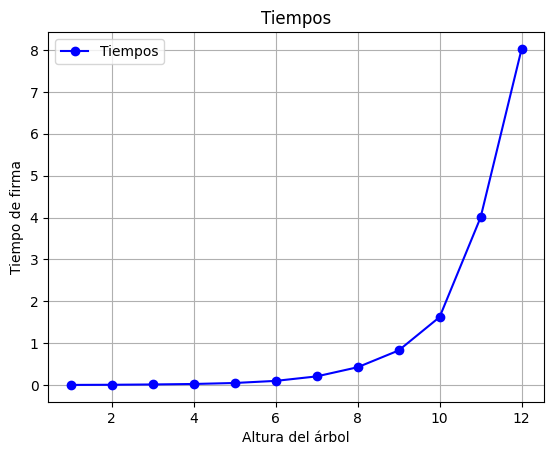

In [ ]:
altura_max = 12
tiempos = np.zeros(altura_max)
for altura_arbol in range(1,altura_max+1): #Entre 1 y 12
  indice=np.random.randint(2**altura_arbol) #Índice aleatorio

  pk,sk_seed = xmss_gen_modified(altura_arbol)

  inicio = time.time()
  signature = xmss_sign_modified("hola",sk_seed,indice,h=altura_arbol)
  fin = time.time()

  tiempos[altura_arbol-1] = fin-inicio

  print(f"Altura: {altura_arbol}")
  print(f"Tiempo de firma: {fin - inicio:.5f} segundos")

x = range(1, len(tiempos) + 1)
plt.plot(x, tiempos, marker='o', linestyle='-', color='b', label='Tiempos')
plt.title("Tiempos")
plt.xlabel("Altura del árbol")
plt.ylabel("Tiempo de firma")
plt.grid(True)
plt.legend()
plt.show()